In [1]:
import pandas as pd
import numpy as np
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

In [2]:
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                start=start_date,
              end=end_date).stack()


[*********************100%%**********************]  503 of 503 completed


1 Failed download:


['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


In [3]:
df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.588034   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716068   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024628   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807270   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     112.216316  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZION      1586100.0  
           ZTS       1463200.0  

[994088 rows x 6 columns]

In [4]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.588034   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716068   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024628   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807270   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     112.216316  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_klass_vol  
date       ticker                                 
2015-09-29 A         2252400.0         -0.000854  
           AAL       7478800.0         -0.000443  
           AAPL    293461600.0         -0.005441  
           ABBV     12842800.0         -0.049280  
           ABT      12287500.0         -0.008237  
...                        ...               ...  
2023-09-26 YUM       1500600.0          0.000037  
           ZBH       3610500.0          0.000224  
           ZBRA       355400.0          0.000133  
           ZION      1586100.0          0.000292  
           ZTS       1463200.0          0.000075  

[994088 rows x 7 columns]

In [5]:
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=10))

In [6]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x),length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length=20).iloc[:,2])

In [7]:
def compute_atr(stock_data):
    atr  = pandas_ta.atr(high = stock_data['high'],
                         low = stock_data['low'], 
                         close = stock_data['close'], 
                         length = 14) 
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level=1, group_keys = False).apply(compute_atr)
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.588034   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716068   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024628   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807270   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     112.216316  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000854        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005441        NaN       NaN   
           ABBV     12842800.0         -0.049280        NaN       NaN   
           ABT      12287500.0         -0.008237        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 YUM       1500600.0          0.000037  31.516658  4.821521   
           ZBH       3610500.0          0.000224  25.378310  4.751923   
           ZBRA       355400.0          0.000133  18.760638  5.400991   
           ZION      1586100.0          0.000292  40.173112  3.527329   
           ZTS       1463200.0          0.000075  34.777948  5.161192   

                     bb_mid   bb_high       atr  
date       ticker                                
2015-09-29 A            NaN       NaN       NaN  
           AAL          NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
...                     ...       ...       ...  
2023-09-26 YUM     4.851489  4.881456  0.142547  
           ZBH     4.791592  4.831260 -0.381708  
           ZBRA    5.539167  5.677342 -0.057389  
           ZION    3.582765  3.638202 -0.161699  
           ZTS     5.220007  5.278822  0.651515  

[994088 rows x 12 columns]

In [8]:
def compute_macd(close):
    macd = pandas_ta.macd(close = close, length =20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())
df['macd'] = df.groupby(level = 1, group_keys= False)['adj close'].apply(compute_macd)
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.588034   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716068   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024628   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807270   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     112.216316  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000854        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005441        NaN       NaN   
           ABBV     12842800.0         -0.049280        NaN       NaN   
           ABT      12287500.0         -0.008237        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 YUM       1500600.0          0.000037  31.516658  4.821521   
           ZBH       3610500.0          0.000224  25.378310  4.751923   
           ZBRA       355400.0          0.000133  18.760638  5.400991   
           ZION      1586100.0          0.000292  40.173112  3.527329   
           ZTS       1463200.0          0.000075  34.777948  5.161192   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2015-09-29 A            NaN       NaN       NaN       NaN  
           AAL          NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2023-09-26 YUM     4.851489  4.881456  0.142547 -1.363696  
           ZBH     4.791592  4.831260 -0.381708 -0.881067  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791  
           ZION    3.582765  3.638202 -0.161699 -0.164625  
           ZTS     5.220007  5.278822  0.651515 -1.188278  

[994088 rows x 13 columns]

In [9]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6 
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.588034   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716068   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024628   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807270   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     112.216316  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000854        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005441        NaN       NaN   
           ABBV     12842800.0         -0.049280        NaN       NaN   
           ABT      12287500.0         -0.008237        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 YUM       1500600.0          0.000037  31.516658  4.821521   
           ZBH       3610500.0          0.000224  25.378310  4.751923   
           ZBRA       355400.0          0.000133  18.760638  5.400991   
           ZION      1586100.0          0.000292  40.173112  3.527329   
           ZTS       1463200.0          0.000075  34.777948  5.161192   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      71.148887  
           AAL          NaN       NaN       NaN       NaN     279.420040  
           AAPL         NaN       NaN       NaN       NaN    7253.216940  
           ABBV         NaN       NaN       NaN       NaN     475.499888  
           ABT          NaN       NaN       NaN       NaN     415.406831  
...                     ...       ...       ...       ...            ...  
2023-09-26 YUM     4.851489  4.881456  0.142547 -1.363696     185.213334  
           ZBH     4.791592  4.831260 -0.381708 -0.881067     405.157010  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZION    3.582765  3.638202 -0.161699 -0.164625      53.263340  
           ZTS     5.220007  5.278822  0.651515 -1.188278     258.178041  

[994088 rows x 14 columns]

In [10]:
# agregate to monthly level and filter top 150 stocks most liquid stocks for each month in order to train the model effectively


In [11]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          136.444139   39.152683         -0.001810  76.875300   
           AAL        287.915797   39.429935         -0.000966  30.521667   
           AAPL      4034.583741   26.924871         -0.003119  54.422243   
           ABBV       343.971745   41.160297         -0.053947  38.593920   
           ABT        213.736346   38.669388         -0.009962  49.288274   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       155.565476   78.967529          0.000040  25.377806   
           ABNB      1633.500725  132.279999          0.000213  36.068308   
           CEG        197.358104  108.239204          0.000220  48.055893   
           GEHC       212.434213   66.179550          0.000185  47.230985   
           KVUE       684.902631   20.426666          0.000136  34.233185   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.549210  3.621664  3.694119 -1.033887  0.567157  
           AAL     3.672028  3.749832  3.827636  0.190822 -0.418772  
           AAPL    3.284211  3.327527  3.370842 -0.967900 -0.142790  
           ABBV    3.745051  3.793320  3.841588 -0.526809  0.145677  
           ABT     3.665571  3.687430  3.709289 -1.064842  0.335557  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.377807  4.423099  4.468390 -1.028320 -1.534536  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.655604  4.695779  4.735953 -0.436215  0.366876  
           GEHC    4.156170  4.213706  4.271243 -0.893478 -1.116463  
           KVUE    3.034066  3.109082  3.184098 -0.899746 -1.435620  

[46937 rows x 9 columns]

In [12]:
#calculate monthly returns for different time horizons as features

In [13]:
g = df.xs('AAPL', level = 1)
g

,adj close,close,high,low,open,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dollar_volume
date,,,,,,,,,,,,,,
2015-09-29,24.716068,27.264999,28.377501,26.965000,28.207500,293461600.0,-0.005441,NaN,NaN,NaN,NaN,NaN,NaN,7253.216940
2015-09-30,24.997082,27.575001,27.885000,27.182501,27.542500,265892000.0,-0.003307,NaN,NaN,NaN,NaN,NaN,NaN,6646.524062
2015-10-01,24.833918,27.395000,27.405001,26.827499,27.267500,255716400.0,-0.003149,NaN,NaN,NaN,NaN,NaN,NaN,6350.440011
2015-10-02,25.015211,27.594999,27.752501,26.887501,27.002501,232079200.0,-0.001756,NaN,NaN,NaN,NaN,NaN,NaN,5805.510181
2015-10-05,25.105869,27.695000,27.842501,27.267500,27.469999,208258800.0,-0.002911,NaN,NaN,NaN,NaN,NaN,NaN,5228.518212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20,175.259109,175.490005,179.699997,175.399994,179.259995,58436200.0,0.000096,41.153925,5.145850,5.198740,5.251630,1.033685,-1.190418,10241.476374
2023-09-21,173.701157,173.929993,176.300003,173.860001,174.550003,63047900.0,0.000088,38.229058,5.141669,5.196726,5.251783,0.977448,-1.293625,10951.493152
2023-09-22,174.560013,174.789993,177.080002,174.050003,174.669998,56725400.0,0.000149,40.805952,5.140439,5.196276,5.252113,0.957909,-1.327877,9901.986551


In [14]:
#calculating monthly gains from a stock

In [15]:
def calculate_returns(df):
    
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                           .pct_change(lag)
                           .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff),
                                                  upper = x.quantile(1-outlier_cutoff)))
                          .add(1)
                          .pow(1/lag)
                          .sub(1))
    return df  
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-11-30 A          108.123606   41.619236         -0.001849  41.510484   
           AAL        298.198621   44.876522          0.000189  72.739099   
           AAPL      3512.220381   25.713816         -0.002422  47.098711   
           ABBV       412.086731   44.699753         -0.039654  51.061013   
           ABT        297.822400   33.597473         -0.007707  35.857751   
...                          ...         ...               ...        ...   
2023-09-30 CTVA       267.929828   50.611397          0.000123  42.747495   
           CARR       254.194531   52.512661          0.001042  34.966581   
           OTIS       155.565476   78.967529          0.000040  25.377806   
           ABNB      1633.500725  132.279999          0.000213  36.068308   
           CEG        197.358104  108.239204          0.000220  48.055893   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2016-11-30 A       3.732786  3.775375  3.817965 -0.888157 -0.331612   
           AAL     3.656155  3.770906  3.885658  0.263773  2.344164   
           AAPL    3.251985  3.281053  3.310121 -1.011998 -0.314781   
           ABBV    3.740504  3.814687  3.888870 -0.617478 -0.257988   
           ABT     3.539788  3.576250  3.612712 -0.981659 -0.575622   
...                     ...       ...       ...       ...       ...   
2023-09-30 CTVA    3.917580  3.951721  3.985863 -0.803714 -0.385746   
           CARR    3.961975  4.031395  4.100814  1.818338 -1.120464   
           OTIS    4.377807  4.423099  4.468390 -1.028320 -1.534536   
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854   
           CEG     4.655604  4.695779  4.735953 -0.436215  0.366876   

                   return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2016-11-30 A        0.009410  -0.033586  -0.020946  -0.006214   0.019227   
           AAL      0.146730   0.127701   0.086493   0.065515   0.014886   
           AAPL    -0.021601  -0.008718   0.015430   0.018834   0.016838   
           ABBV     0.089997  -0.013645  -0.014453  -0.002749   0.015097   
           ABT     -0.029817  -0.048194  -0.030325  -0.004603   0.000125   
...                      ...        ...        ...        ...        ...   
2023-09-30 CTVA     0.005544  -0.049805  -0.038402  -0.027278  -0.015197   
           CARR    -0.082332  -0.059093   0.019790   0.025342   0.028590   
           OTIS    -0.073174  -0.064483  -0.036530  -0.009024   0.002663   
           ABNB     0.005549  -0.067704   0.010603   0.010289   0.048608   
           CEG      0.041571   0.060899   0.059165   0.056503   0.026987   

                   return_12m  
date       ticker              
2016-11-30 A         0.005104  
           AAL       0.010841  
           AAPL     -0.003828  
           ABBV      0.006898  
           ABT      -0.011648  
...                       ...  
2023-09-30 CTVA     -0.008915  
           CARR      0.034814  
           OTIS      0.019569  
           ABNB      0.019401  
           CEG       0.023339  

[40924 rows x 15 columns]

In [16]:
#fama french factors 

In [17]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2X3', 
               'famafrench', 
               start = '2010' )[0].drop('RF', axis=1)
factor_data.index = pd.to_datetime(factor_data.index.to_timestamp())
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2016-11-30 A       0.0486  0.0707  0.0821 -0.0018  0.0370   0.009410
           AAL     0.0486  0.0707  0.0821 -0.0018  0.0370   0.146730
           AAPL    0.0486  0.0707  0.0821 -0.0018  0.0370  -0.021601
           ABBV    0.0486  0.0707  0.0821 -0.0018  0.0370   0.089997
           ABT     0.0486  0.0707  0.0821 -0.0018  0.0370  -0.029817
...                   ...     ...     ...     ...     ...        ...
2023-09-30 YUM    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.041506
           ZBH    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.055910
           ZBRA   -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.185630
           ZION   -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.042535
           ZTS    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.071597

[40924 rows x 6 columns]

In [18]:
#filter out stocks with less than 10 months of data 

In [19]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2016-11-30 A       0.0486  0.0707  0.0821 -0.0018  0.0370   0.009410
           AAL     0.0486  0.0707  0.0821 -0.0018  0.0370   0.146730
           AAPL    0.0486  0.0707  0.0821 -0.0018  0.0370  -0.021601
           ABBV    0.0486  0.0707  0.0821 -0.0018  0.0370   0.089997
           ABT     0.0486  0.0707  0.0821 -0.0018  0.0370  -0.029817
...                   ...     ...     ...     ...     ...        ...
2023-09-30 YUM    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.041506
           ZBH    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.055910
           ZBRA   -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.185630
           ZION   -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.042535
           ZTS    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.071597

[40916 rows x 6 columns]

In [20]:
#calculate rolling factor betas 

In [21]:
betas = (factor_data.groupby(level=1, 
                    group_keys=False).apply(lambda x: RollingOLS(endog=x['return_1m'],
                                                    exog=sm.add_constant(x.drop('return_1m',axis=1)),
                                                    window = min(24,x.shape[0]),
                                                    min_nobs=len(x.columns)+1)
        .fit(params_only = True)
        .params
        .drop('const',axis=1))) 
betas
    

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2016-11-30 A            NaN       NaN       NaN       NaN       NaN
           AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 YUM     0.734628  0.648213 -0.356068  1.063334  0.716488
           ZBH     0.841922  0.112529 -0.564877 -0.638166  1.426979
           ZBRA    1.433340  1.119102 -0.481143  0.971507 -0.026444
           ZION    0.580123  1.712812  2.138329 -0.362248 -1.587625
           ZTS     0.689076  1.051482 -0.389287  1.218147 -0.066375

[40916 rows x 5 columns]

In [22]:
data = data.join(betas.groupby('ticker').shift())
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-11-30 A          108.123606   41.619236         -0.001849  41.510484   
           AAL        298.198621   44.876522          0.000189  72.739099   
           AAPL      3512.220381   25.713816         -0.002422  47.098711   
           ABBV       412.086731   44.699753         -0.039654  51.061013   
           ABT        297.822400   33.597473         -0.007707  35.857751   
...                          ...         ...               ...        ...   
2023-09-30 CTVA       267.929828   50.611397          0.000123  42.747495   
           CARR       254.194531   52.512661          0.001042  34.966581   
           OTIS       155.565476   78.967529          0.000040  25.377806   
           ABNB      1633.500725  132.279999          0.000213  36.068308   
           CEG        197.358104  108.239204          0.000220  48.055893   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2016-11-30 A       3.732786  3.775375  3.817965 -0.888157 -0.331612   
           AAL     3.656155  3.770906  3.885658  0.263773  2.344164   
           AAPL    3.251985  3.281053  3.310121 -1.011998 -0.314781   
           ABBV    3.740504  3.814687  3.888870 -0.617478 -0.257988   
           ABT     3.539788  3.576250  3.612712 -0.981659 -0.575622   
...                     ...       ...       ...       ...       ...   
2023-09-30 CTVA    3.917580  3.951721  3.985863 -0.803714 -0.385746   
           CARR    3.961975  4.031395  4.100814  1.818338 -1.120464   
           OTIS    4.377807  4.423099  4.468390 -1.028320 -1.534536   
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854   
           CEG     4.655604  4.695779  4.735953 -0.436215  0.366876   

                   return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2016-11-30 A        0.009410  -0.033586  -0.020946  -0.006214   0.019227   
           AAL      0.146730   0.127701   0.086493   0.065515   0.014886   
           AAPL    -0.021601  -0.008718   0.015430   0.018834   0.016838   
           ABBV     0.089997  -0.013645  -0.014453  -0.002749   0.015097   
           ABT     -0.029817  -0.048194  -0.030325  -0.004603   0.000125   
...                      ...        ...        ...        ...        ...   
2023-09-30 CTVA     0.005544  -0.049805  -0.038402  -0.027278  -0.015197   
           CARR    -0.082332  -0.059093   0.019790   0.025342   0.028590   
           OTIS    -0.073174  -0.064483  -0.036530  -0.009024   0.002663   
           ABNB     0.005549  -0.067704   0.010603   0.010289   0.048608   
           CEG      0.041571   0.060899   0.059165   0.056503   0.026987   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
date       ticker                                                       
2016-11-30 A         0.005104       NaN       NaN       NaN       NaN   
           AAL       0.010841       NaN       NaN       NaN       NaN   
           AAPL     -0.003828       NaN       NaN       NaN       NaN   
           ABBV      0.006898       NaN       NaN       NaN       NaN   
           ABT      -0.011648       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2023-09-30 CTVA     -0.008915  1.012079  0.649377 -0.087037 -0.348807   
           CARR      0.034814  1.337135  1.007626  0.171466  0.629715   
           OTIS      0.019569  0.823318  0.726113 -0.027591  1.149819   
           ABNB      0.019401       NaN       NaN       NaN       NaN   
           CEG       0.023339       NaN       NaN       NaN       NaN   

                        CMA  
date       ticker            
2016-11-30 A            NaN  
           AAL          NaN  
           AAPL         NaN  
    

In [23]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA' ] 
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()
data

dollar_volume  adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2016-11-30 A          108.123606  41.619236         -0.001849  41.510484   
           AAL        298.198621  44.876522          0.000189  72.739099   
           AAPL      3512.220381  25.713816         -0.002422  47.098711   
           ABBV       412.086731  44.699753         -0.039654  51.061013   
           ABT        297.822400  33.597473         -0.007707  35.857751   
...                          ...        ...               ...        ...   
2023-09-30 FOX         34.804903  28.540001          0.000212  39.773988   
           DOW        217.763934  49.796383          0.000081  31.492420   
           CTVA       267.929828  50.611397          0.000123  42.747495   
           CARR       254.194531  52.512661          0.001042  34.966581   
           OTIS       155.565476  78.967529          0.000040  25.377806   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2016-11-30 A       3.732786  3.775375  3.817965 -0.888157 -0.331612   
           AAL     3.656155  3.770906  3.885658  0.263773  2.344164   
           AAPL    3.251985  3.281053  3.310121 -1.011998 -0.314781   
           ABBV    3.740504  3.814687  3.888870 -0.617478 -0.257988   
           ABT     3.539788  3.576250  3.612712 -0.981659 -0.575622   
...                     ...       ...       ...       ...       ...   
2023-09-30 FOX     3.367636  3.410422  3.453208 -0.864258 -0.600102   
           DOW     3.925799  3.980395  4.034991 -1.401193 -0.736530   
           CTVA    3.917580  3.951721  3.985863 -0.803714 -0.385746   
           CARR    3.961975  4.031395  4.100814  1.818338 -1.120464   
           OTIS    4.377807  4.423099  4.468390 -1.028320 -1.534536   

                   return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2016-11-30 A        0.009410  -0.033586  -0.020946  -0.006214   0.019227   
           AAL      0.146730   0.127701   0.086493   0.065515   0.014886   
           AAPL    -0.021601  -0.008718   0.015430   0.018834   0.016838   
           ABBV     0.089997  -0.013645  -0.014453  -0.002749   0.015097   
           ABT     -0.029817  -0.048194  -0.030325  -0.004603   0.000125   
...                      ...        ...        ...        ...        ...   
2023-09-30 FOX     -0.064875  -0.042682  -0.033559  -0.013911   0.002156   
           DOW     -0.074780  -0.048475  -0.013526  -0.009244   0.004535   
           CTVA     0.005544  -0.049805  -0.038402  -0.027278  -0.015197   
           CARR    -0.082332  -0.059093   0.019790   0.025342   0.028590   
           OTIS    -0.073174  -0.064483  -0.036530  -0.009024   0.002663   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
date       ticker                                                       
2016-11-30 A         0.005104  1.067254 -0.095030 -0.097216 -0.023146   
           AAL       0.010841  1.343509  1.145641  0.655440  0.663795   
           AAPL     -0.003828  1.116547 -0.228556 -0.607444  0.634581   
           ABBV      0.006898  0.596029  0.161685  0.108148 -0.174108   
           ABT      -0.011648  0.852124 -0.250180 -0.503837  0.123234   
...                       ...       ...       ...       ...       ...   
2023-09-30 FOX       0.001470  0.609183 -0.216843  0.760594 -0.532817   
           DOW       0.016126  1.092730  0.325837  0.137536 -0.134985   
           CTVA     -0.008915  1.012079  0.649377 -0.087037 -0.348807   
           CARR      0.034814  1.337135  1.007626  0.171466  0.629715   
           OTIS      0.019569  0.823318  0.726113 -0.027591  1.149819   

                        CMA  
date       ticker            
2016-11-30 A       0.123157  
           AAL     0.398970  
           AAPL   -0.074090  
           ABBV  

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 40895 entries, (Timestamp('2016-11-30 00:00:00'), 'A') to (Timestamp('2023-09-30 00:00:00'), 'OTIS')
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dollar_volume     40895 non-null  float64
 1   adj close         40895 non-null  float64
 2   garman_klass_vol  40895 non-null  float64
 3   rsi               40895 non-null  float64
 4   bb_low            40895 non-null  float64
 5   bb_mid            40895 non-null  float64
 6   bb_high           40895 non-null  float64
 7   atr               40895 non-null  float64
 8   macd              40895 non-null  float64
 9   return_1m         40895 non-null  float64
 10  return_2m         40895 non-null  float64
 11  return_3m         40895 non-null  float64
 12  return_6m         40895 non-null  float64
 13  return_9m         40895 non-null  float64
 14  return_12m        40895 non-null  float64
 15  Mkt-RF      

In [25]:
data = data.drop('adj close', axis=1) 
data

dollar_volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                         
2016-11-30 A          108.123606         -0.001849  41.510484  3.732786   
           AAL        298.198621          0.000189  72.739099  3.656155   
           AAPL      3512.220381         -0.002422  47.098711  3.251985   
           ABBV       412.086731         -0.039654  51.061013  3.740504   
           ABT        297.822400         -0.007707  35.857751  3.539788   
...                          ...               ...        ...       ...   
2023-09-30 FOX         34.804903          0.000212  39.773988  3.367636   
           DOW        217.763934          0.000081  31.492420  3.925799   
           CTVA       267.929828          0.000123  42.747495  3.917580   
           CARR       254.194531          0.001042  34.966581  3.961975   
           OTIS       155.565476          0.000040  25.377806  4.377807   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2016-11-30 A       3.775375  3.817965 -0.888157 -0.331612   0.009410   
           AAL     3.770906  3.885658  0.263773  2.344164   0.146730   
           AAPL    3.281053  3.310121 -1.011998 -0.314781  -0.021601   
           ABBV    3.814687  3.888870 -0.617478 -0.257988   0.089997   
           ABT     3.576250  3.612712 -0.981659 -0.575622  -0.029817   
...                     ...       ...       ...       ...        ...   
2023-09-30 FOX     3.410422  3.453208 -0.864258 -0.600102  -0.064875   
           DOW     3.980395  4.034991 -1.401193 -0.736530  -0.074780   
           CTVA    3.951721  3.985863 -0.803714 -0.385746   0.005544   
           CARR    4.031395  4.100814  1.818338 -1.120464  -0.082332   
           OTIS    4.423099  4.468390 -1.028320 -1.534536  -0.073174   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2016-11-30 A       -0.033586  -0.020946  -0.006214   0.019227    0.005104   
           AAL      0.127701   0.086493   0.065515   0.014886    0.010841   
           AAPL    -0.008718   0.015430   0.018834   0.016838   -0.003828   
           ABBV    -0.013645  -0.014453  -0.002749   0.015097    0.006898   
           ABT     -0.048194  -0.030325  -0.004603   0.000125   -0.011648   
...                      ...        ...        ...        ...         ...   
2023-09-30 FOX     -0.042682  -0.033559  -0.013911   0.002156    0.001470   
           DOW     -0.048475  -0.013526  -0.009244   0.004535    0.016126   
           CTVA    -0.049805  -0.038402  -0.027278  -0.015197   -0.008915   
           CARR    -0.059093   0.019790   0.025342   0.028590    0.034814   
           OTIS    -0.064483  -0.036530  -0.009024   0.002663    0.019569   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2016-11-30 A       1.067254 -0.095030 -0.097216 -0.023146  0.123157  
           AAL     1.343509  1.145641  0.655440  0.663795  0.398970  
           AAPL    1.116547 -0.228556 -0.607444  0.634581 -0.074090  
           ABBV    0.596029  0.161685  0.108148 -0.174108 -0.036496  
           ABT     0.852124 -0.250180 -0.503837  0.123234  0.906604  
...                     ...       ...       ...       ...       ...  
2023-09-30 FOX     0.609183 -0.216843  0.760594 -0.532817 -0.549565  
           DOW     1.092730  0.325837  0.137536 -0.134985  0.956312  
           CTVA    1.012079  0.649377 -0.087037 -0.348807  1.254948  
           CARR    1.337135  1.007626  0.171466  0.629715 -0.380310  
           OTIS    0.823318  0.726113 -0.027591  1.149819  0.246895  

[40895 rows x 19 columns]

In [29]:
#apply predefined centroids

In [30]:
target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 6] = target_rsi_values
initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [26]:
#now split the data to clusters

In [38]:
from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data


dollar_volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                         
2016-11-30 A          108.123606         -0.001849  41.510484  3.732786   
           AAL        298.198621          0.000189  72.739099  3.656155   
           AAPL      3512.220381         -0.002422  47.098711  3.251985   
           ABBV       412.086731         -0.039654  51.061013  3.740504   
           ABT        297.822400         -0.007707  35.857751  3.539788   
...                          ...               ...        ...       ...   
2023-09-30 FOX         34.804903          0.000212  39.773988  3.367636   
           DOW        217.763934          0.000081  31.492420  3.925799   
           CTVA       267.929828          0.000123  42.747495  3.917580   
           CARR       254.194531          0.001042  34.966581  3.961975   
           OTIS       155.565476          0.000040  25.377806  4.377807   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2016-11-30 A       3.775375  3.817965 -0.888157 -0.331612   0.009410   
           AAL     3.770906  3.885658  0.263773  2.344164   0.146730   
           AAPL    3.281053  3.310121 -1.011998 -0.314781  -0.021601   
           ABBV    3.814687  3.888870 -0.617478 -0.257988   0.089997   
           ABT     3.576250  3.612712 -0.981659 -0.575622  -0.029817   
...                     ...       ...       ...       ...        ...   
2023-09-30 FOX     3.410422  3.453208 -0.864258 -0.600102  -0.064875   
           DOW     3.980395  4.034991 -1.401193 -0.736530  -0.074780   
           CTVA    3.951721  3.985863 -0.803714 -0.385746   0.005544   
           CARR    4.031395  4.100814  1.818338 -1.120464  -0.082332   
           OTIS    4.423099  4.468390 -1.028320 -1.534536  -0.073174   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2016-11-30 A       -0.033586  -0.020946  -0.006214   0.019227    0.005104   
           AAL      0.127701   0.086493   0.065515   0.014886    0.010841   
           AAPL    -0.008718   0.015430   0.018834   0.016838   -0.003828   
           ABBV    -0.013645  -0.014453  -0.002749   0.015097    0.006898   
           ABT     -0.048194  -0.030325  -0.004603   0.000125   -0.011648   
...                      ...        ...        ...        ...         ...   
2023-09-30 FOX     -0.042682  -0.033559  -0.013911   0.002156    0.001470   
           DOW     -0.048475  -0.013526  -0.009244   0.004535    0.016126   
           CTVA    -0.049805  -0.038402  -0.027278  -0.015197   -0.008915   
           CARR    -0.059093   0.019790   0.025342   0.028590    0.034814   
           OTIS    -0.064483  -0.036530  -0.009024   0.002663    0.019569   

                     Mkt-RF       SMB       HML       RMW       CMA  cluster  
date       ticker                                                             
2016-11-30 A       1.067254 -0.095030 -0.097216 -0.023146  0.123157        1  
           AAL     1.343509  1.145641  0.655440  0.663795  0.398970        1  
           AAPL    1.116547 -0.228556 -0.607444  0.634581 -0.074090        2  
           ABBV    0.596029  0.161685  0.108148 -0.174108 -0.036496        0  
           ABT     0.852124 -0.250180 -0.503837  0.123234  0.906604        1  
...                     ...       ...       ...       ...       ...      ...  
2023-09-30 FOX     0.609183 -0.216843  0.760594 -0.532817 -0.549565        0  
           DOW     1.092730  0.325837  0.137536 -0.134985  0.956312        0  
           CTVA    1.012079  0.649377 -0.087037 -0.348807  1.254948        0  
           CARR    1.337135  1.007626  0.171466  0.629715 -0.380310        0  
           OTIS    0.823318  0.726113 -0.027591  1.149819  0.246895        0  

[40895 rows x 20 columns]

In [41]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

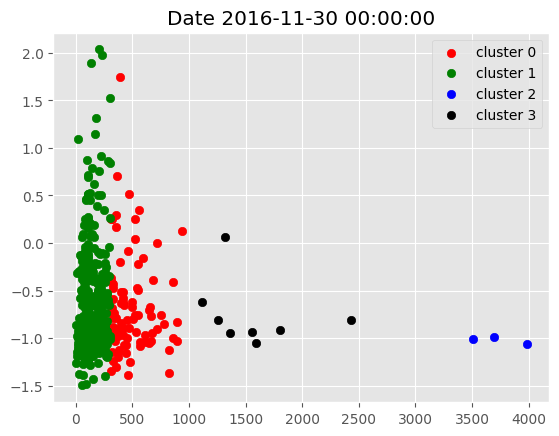

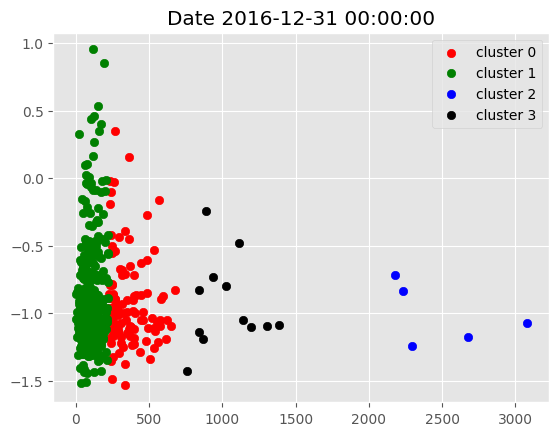

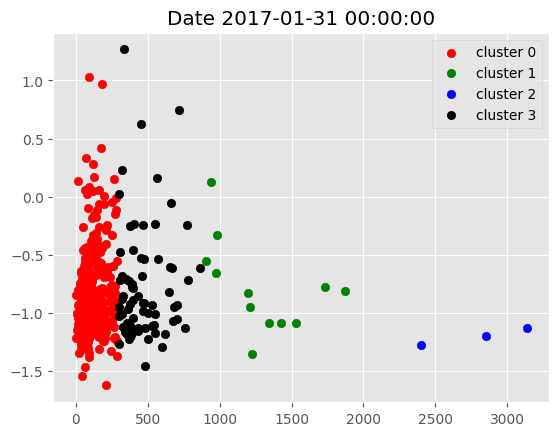

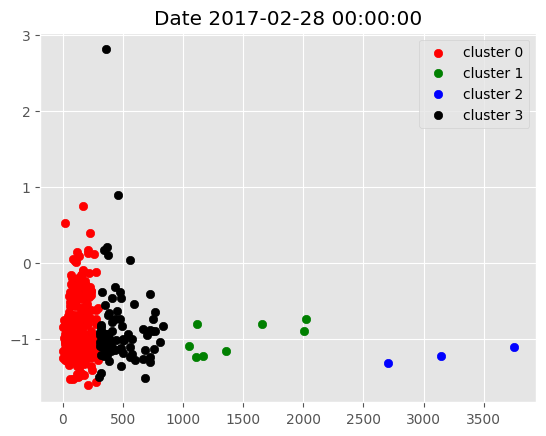

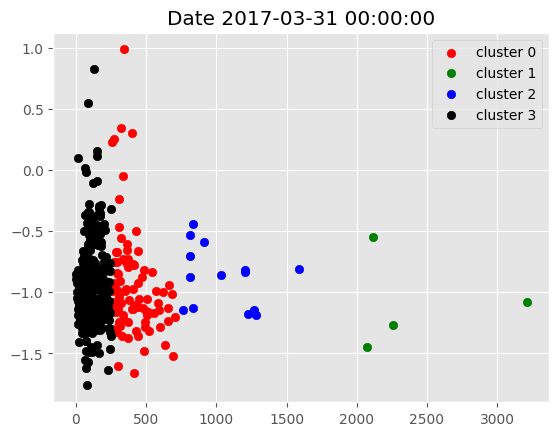

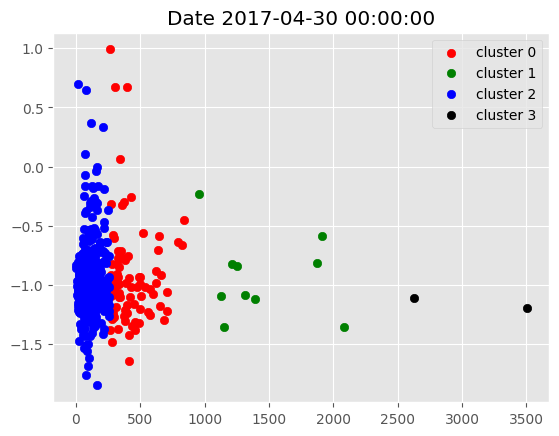

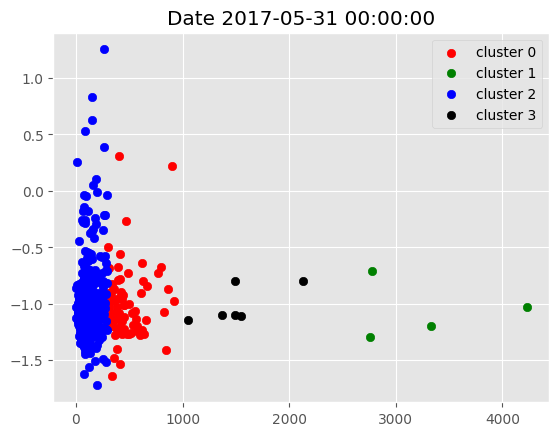

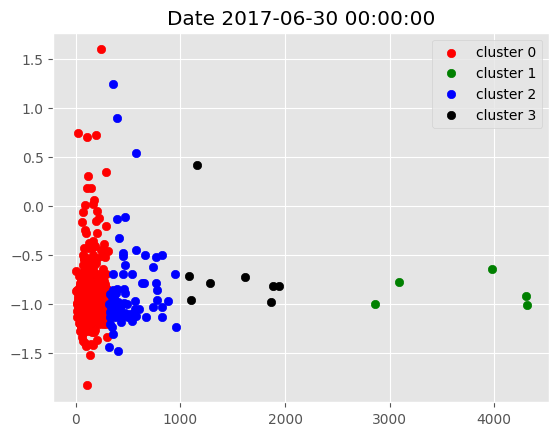

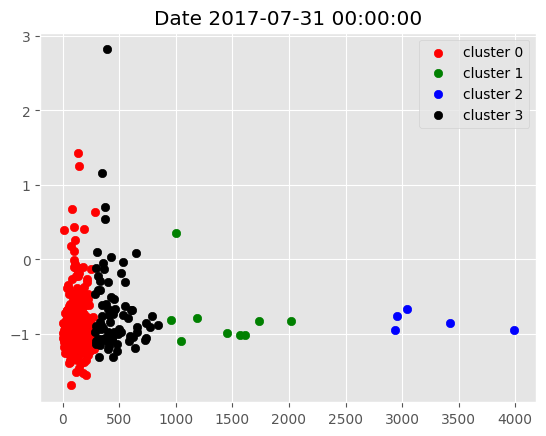

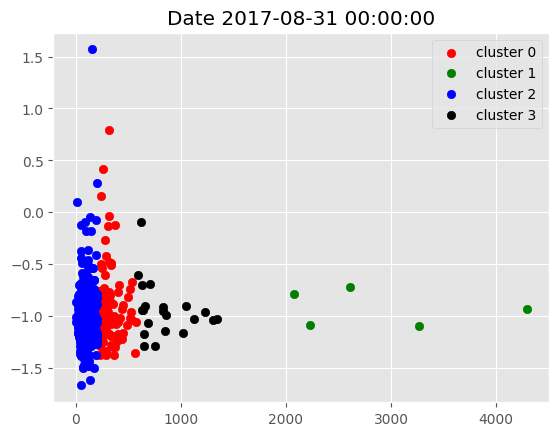

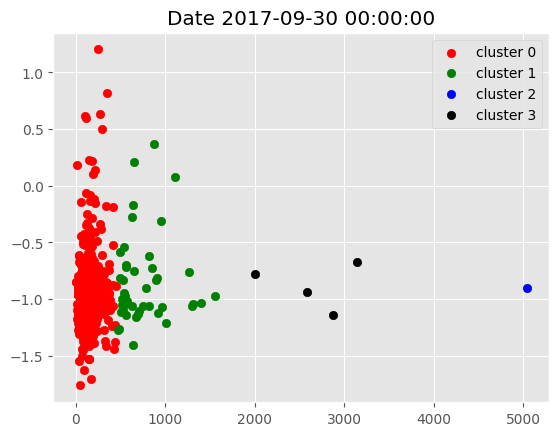

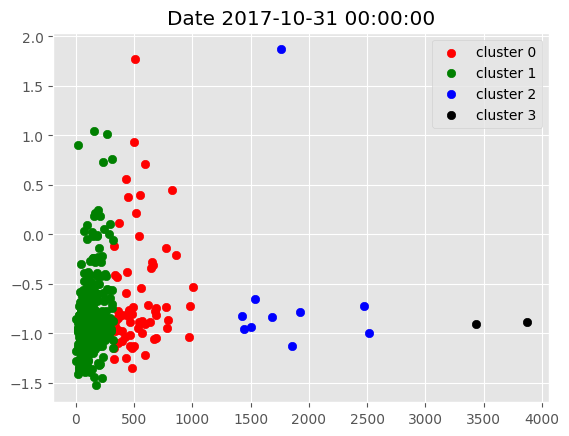

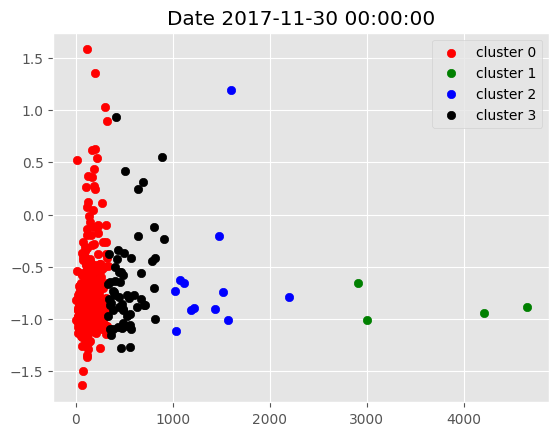

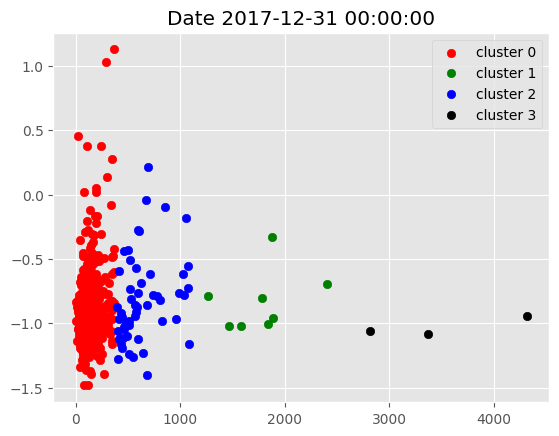

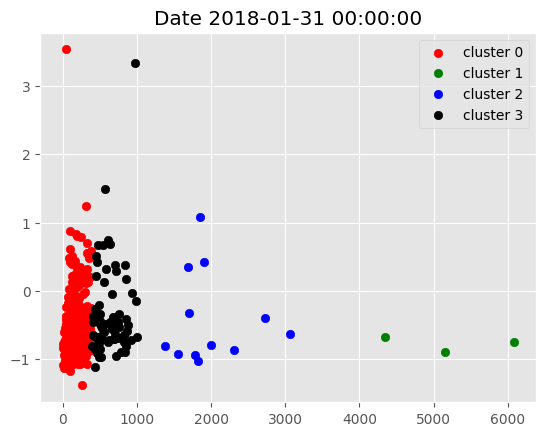

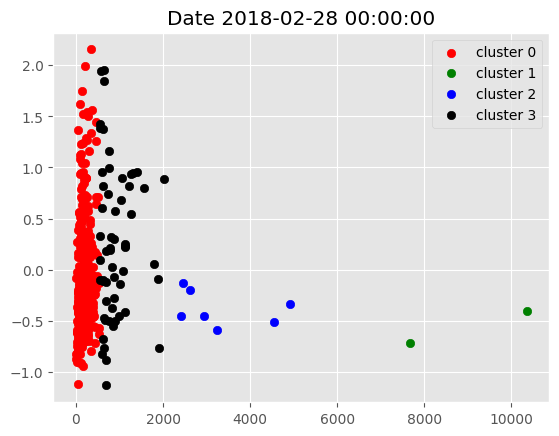

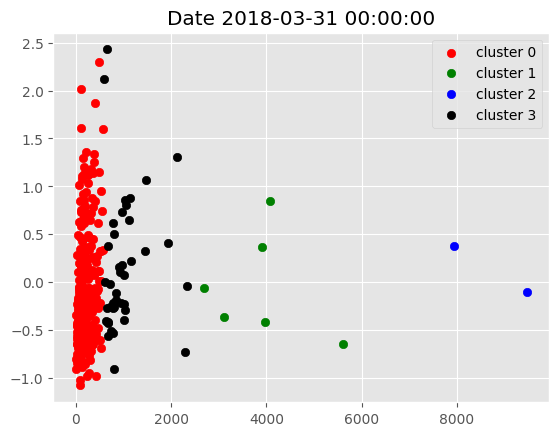

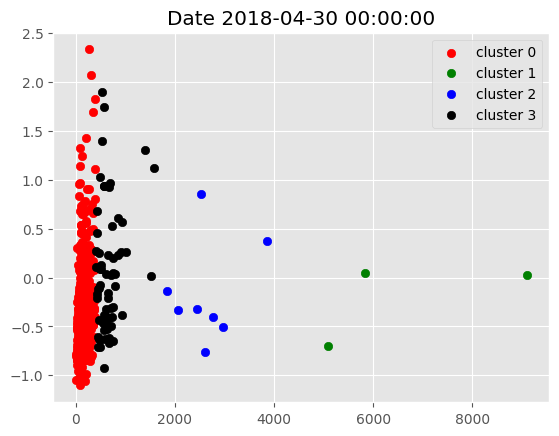

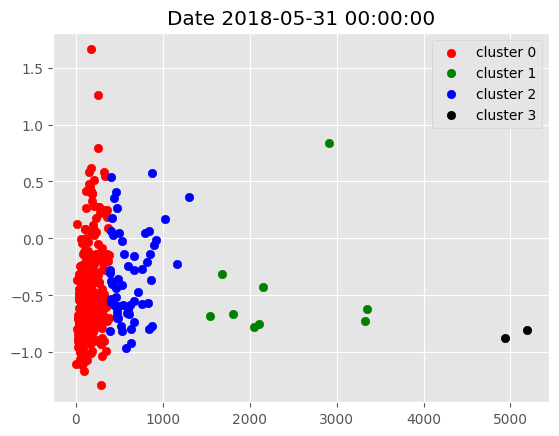

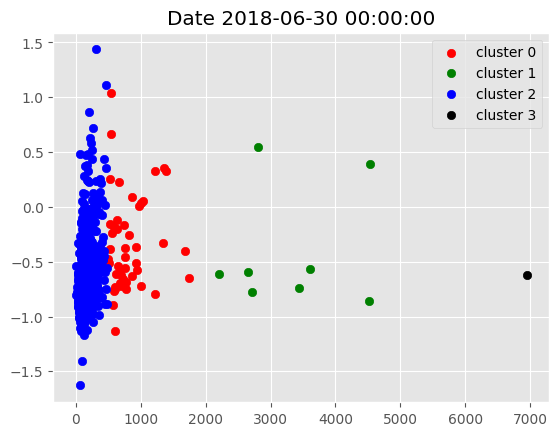

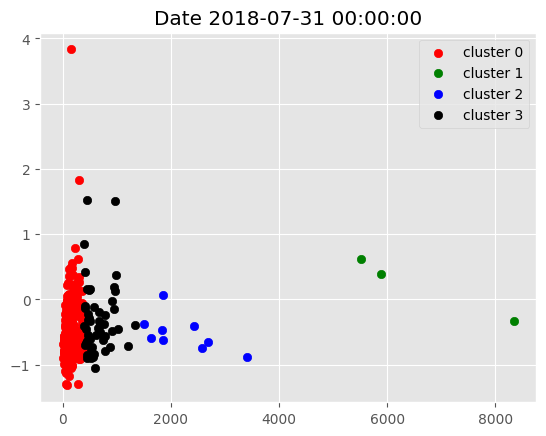

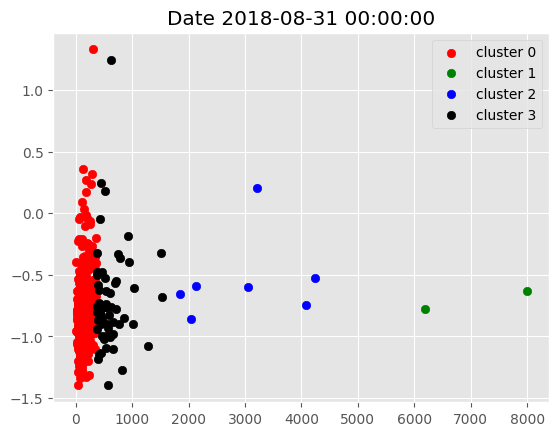

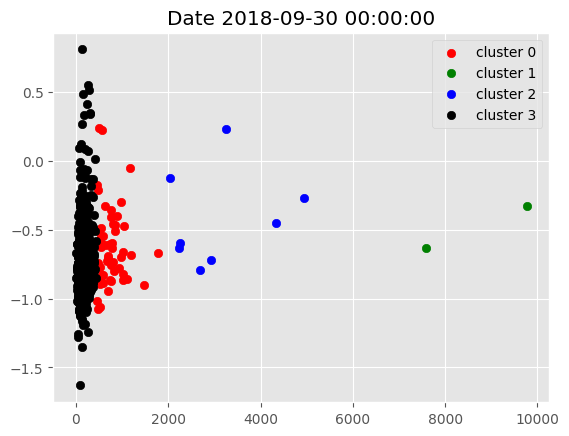

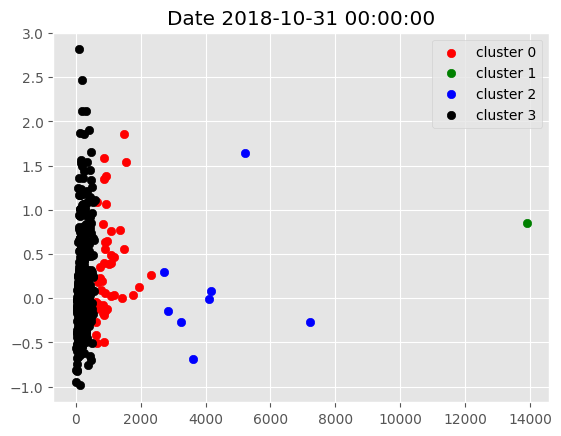

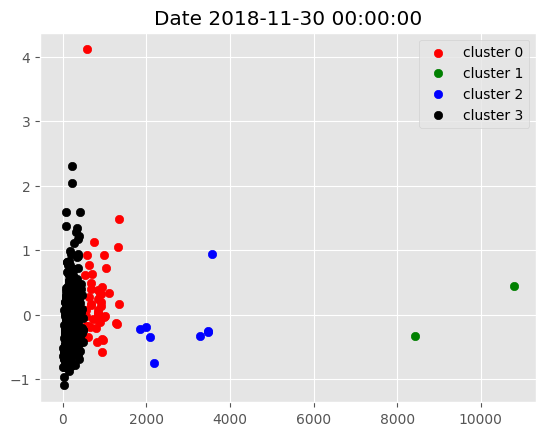

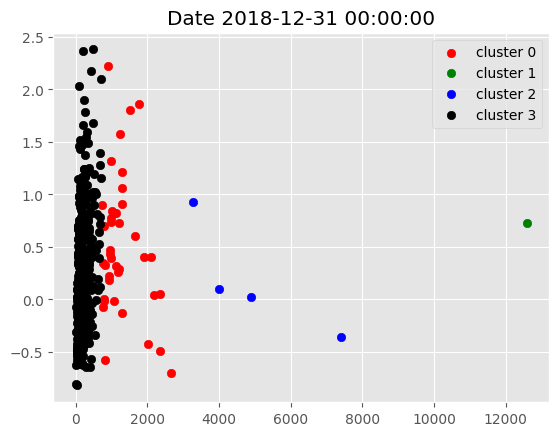

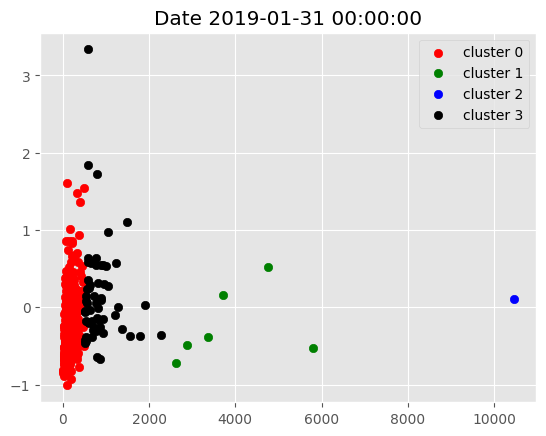

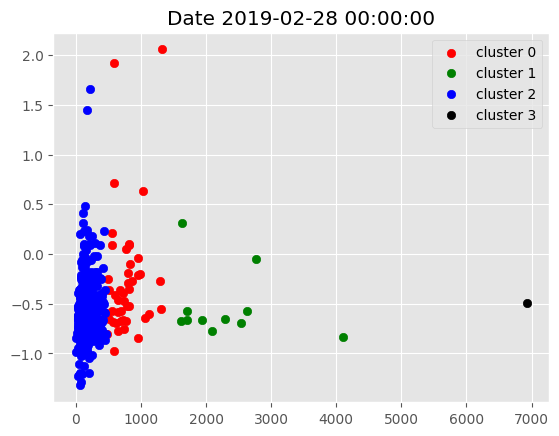

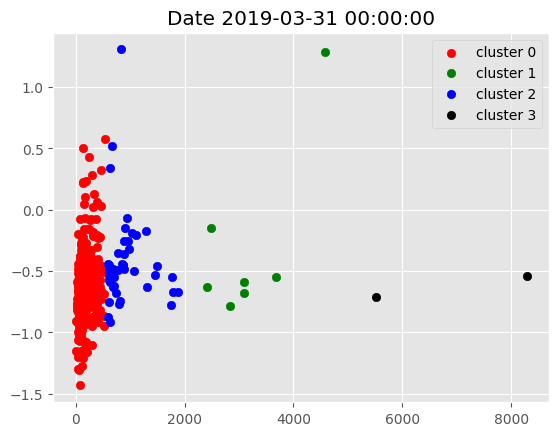

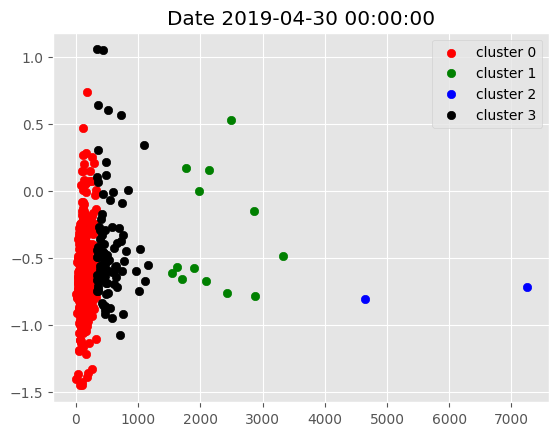

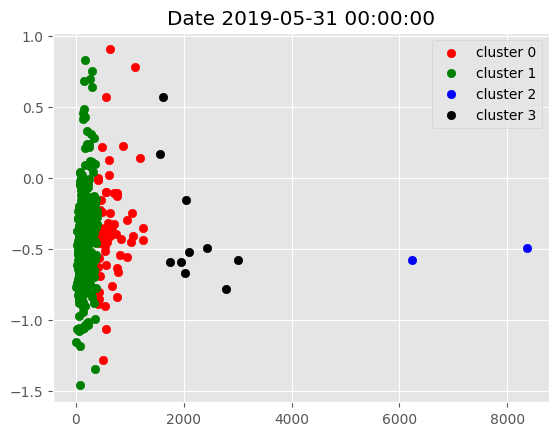

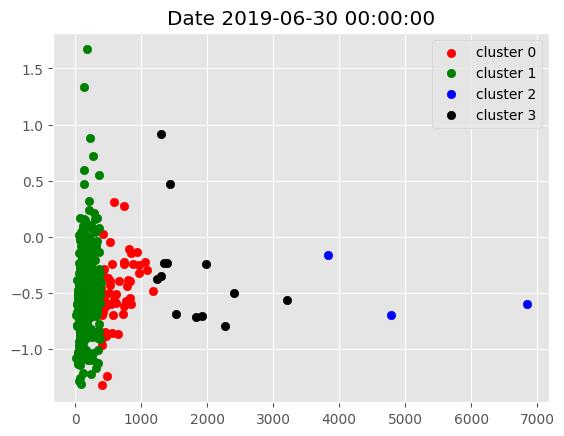

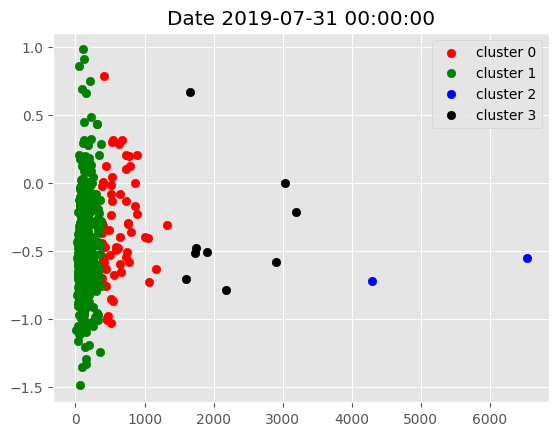

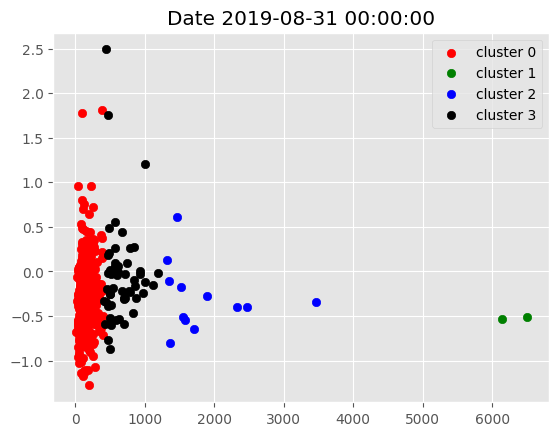

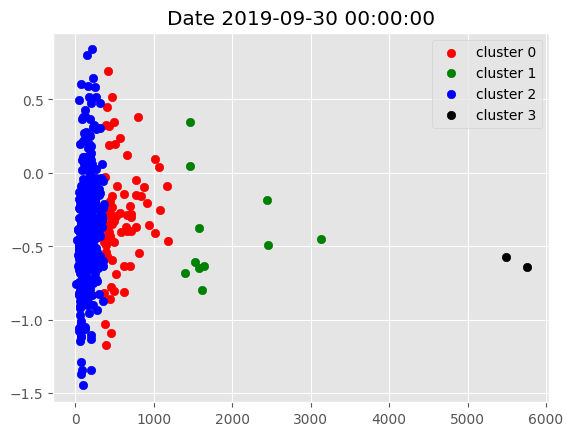

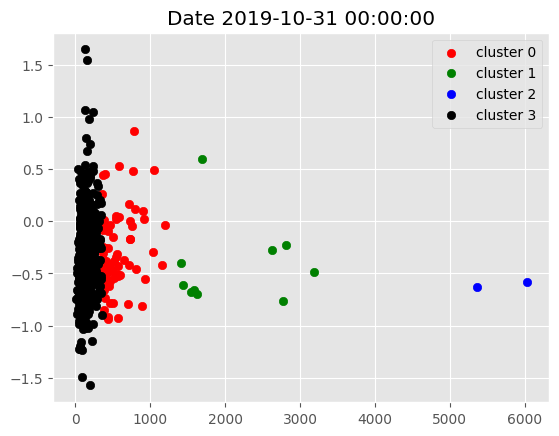

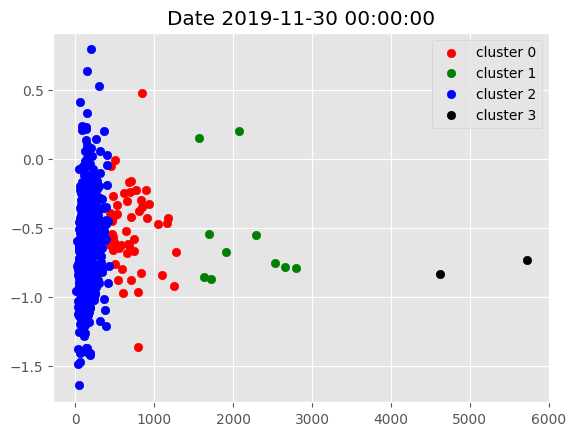

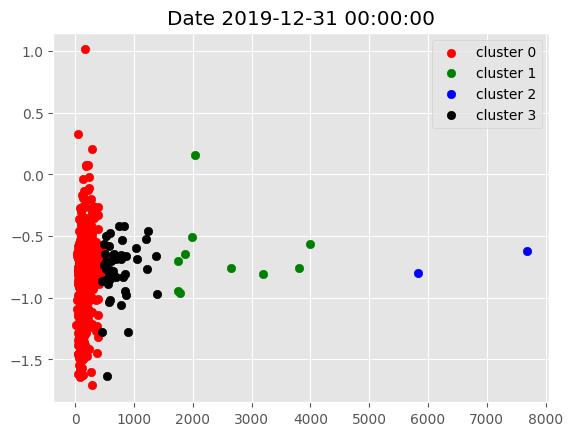

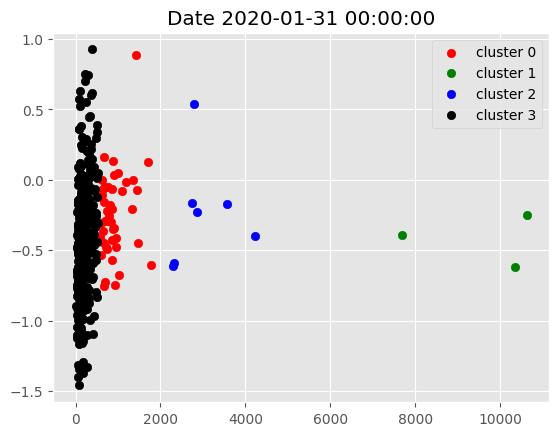

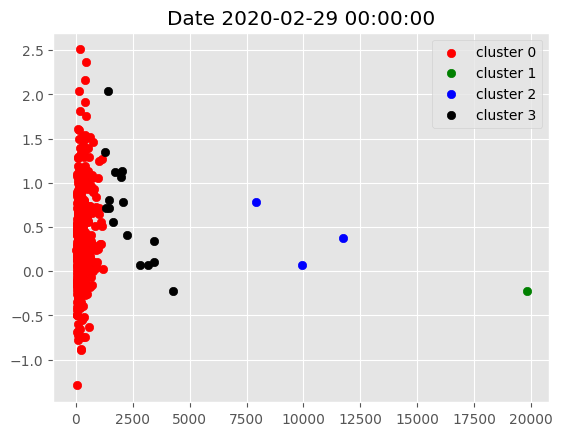

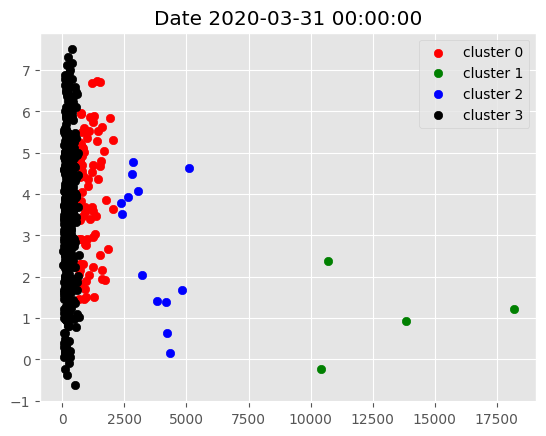

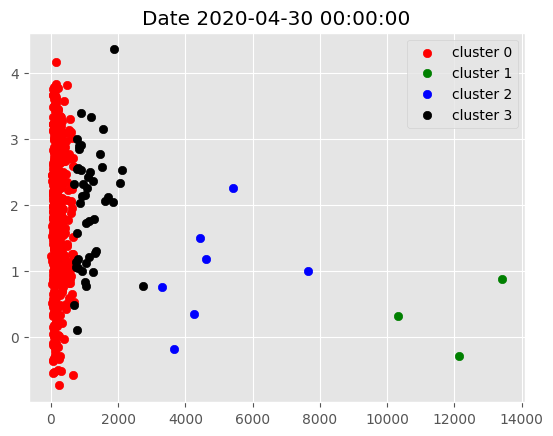

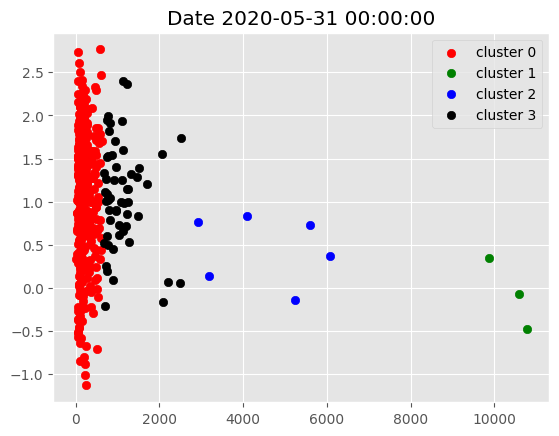

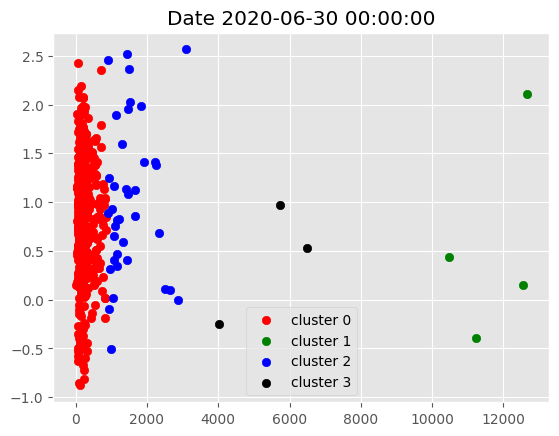

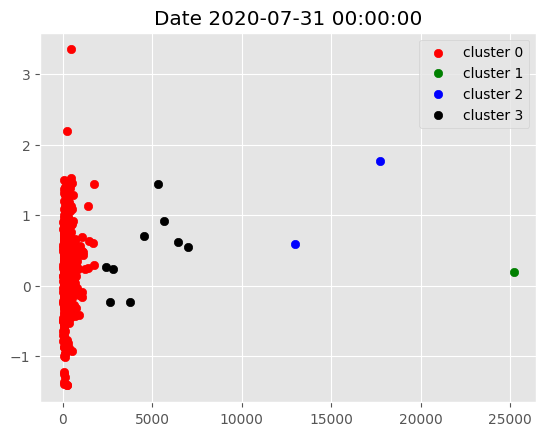

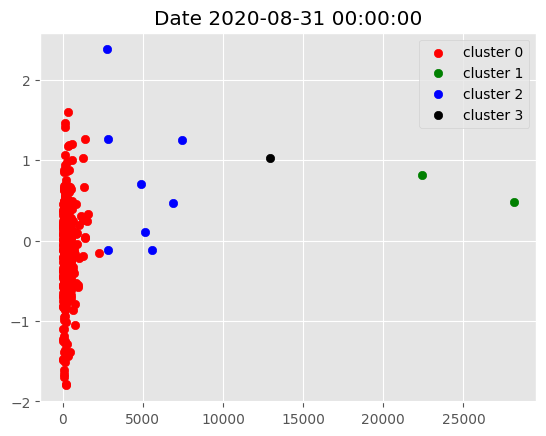

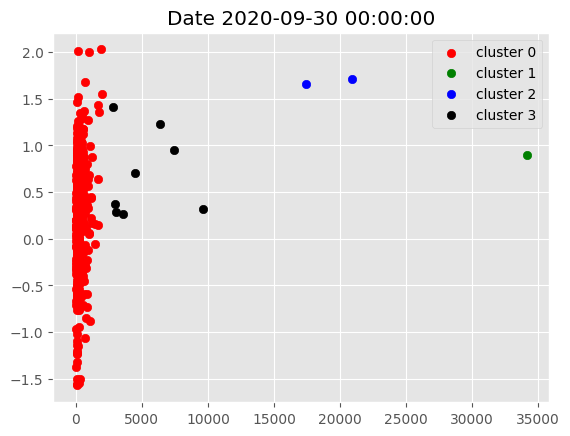

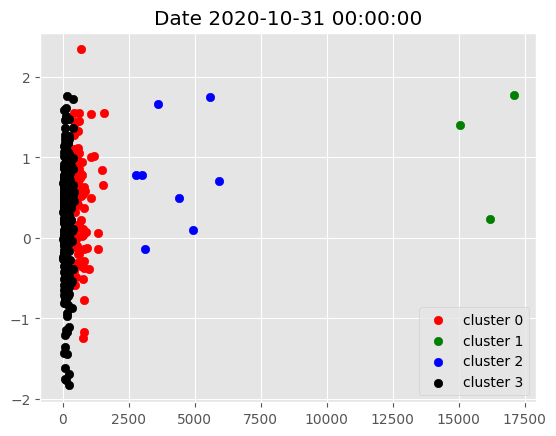

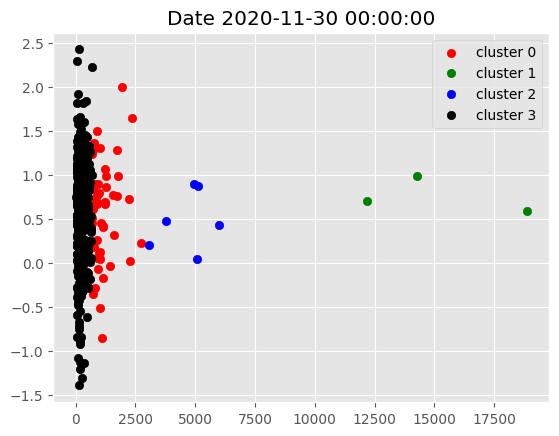

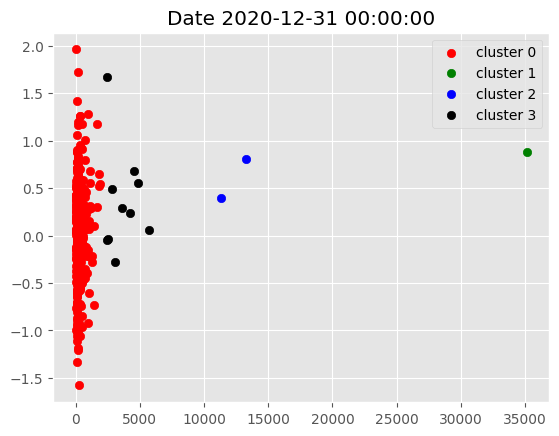

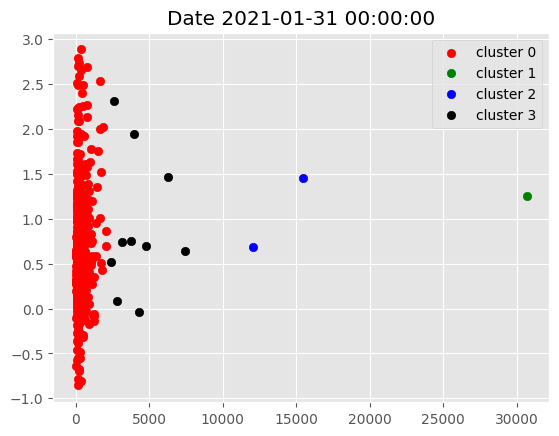

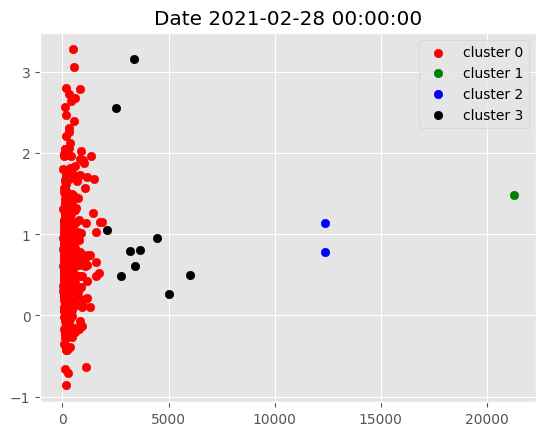

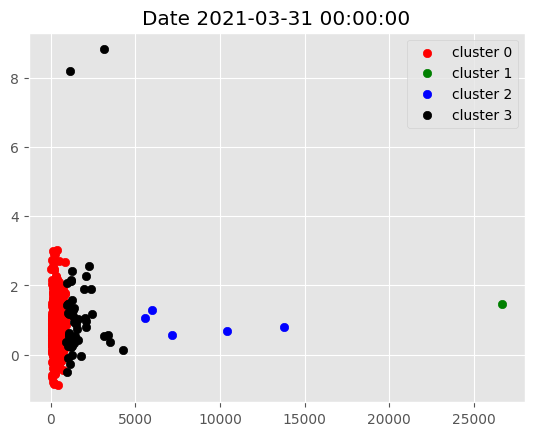

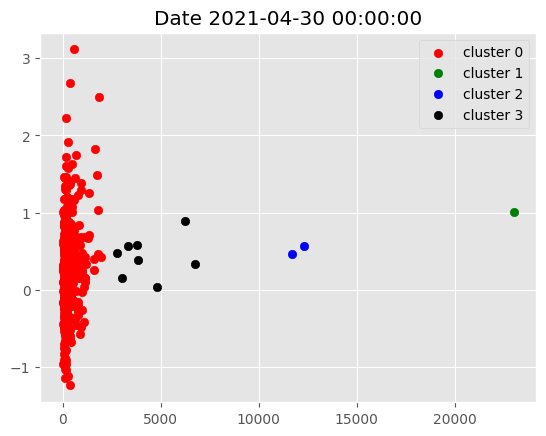

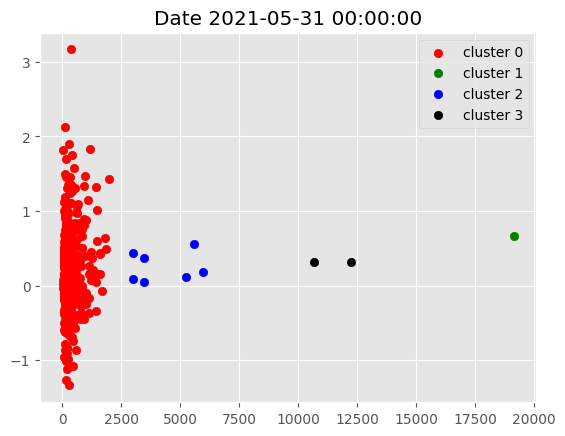

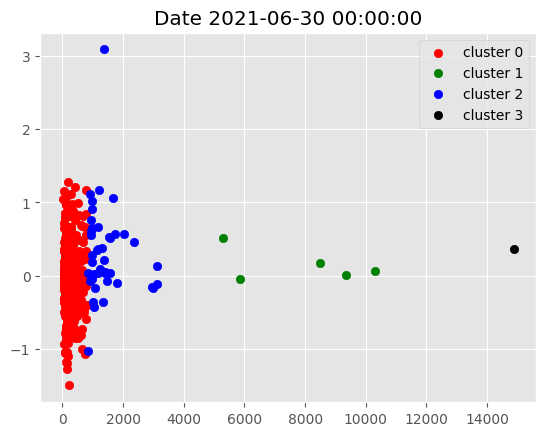

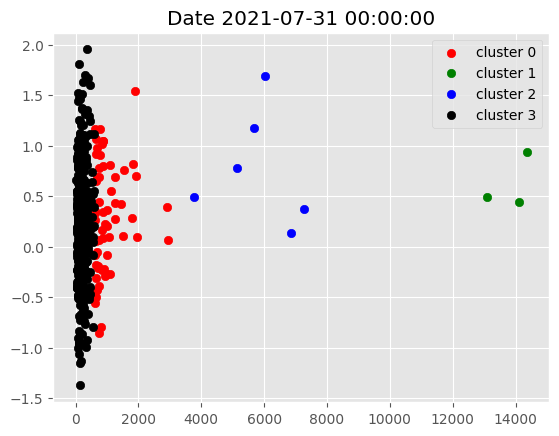

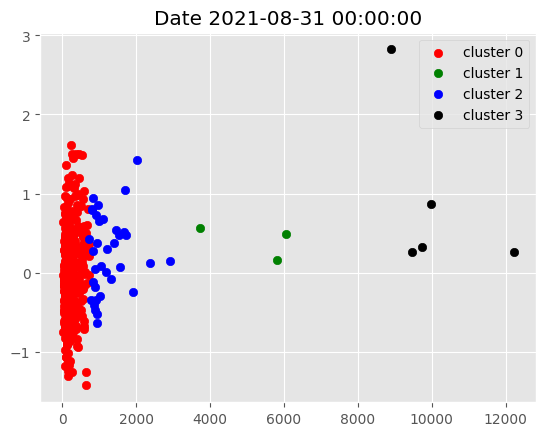

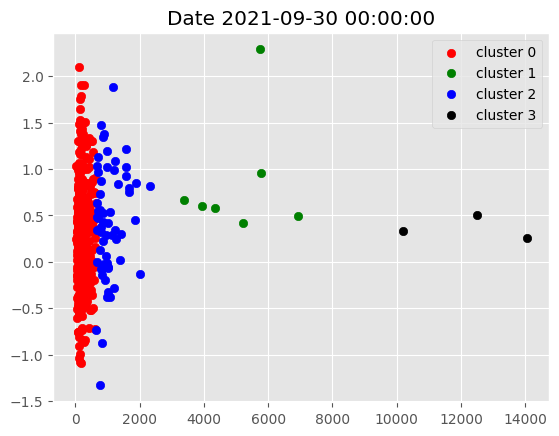

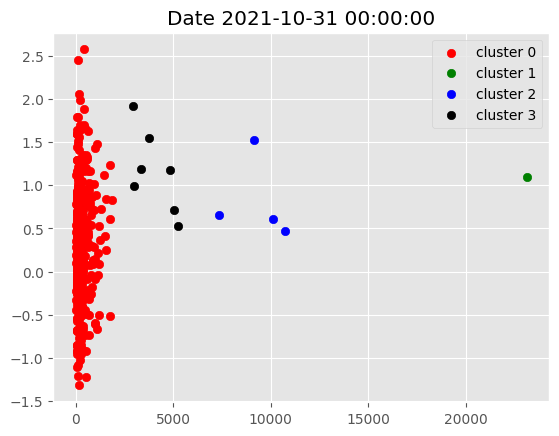

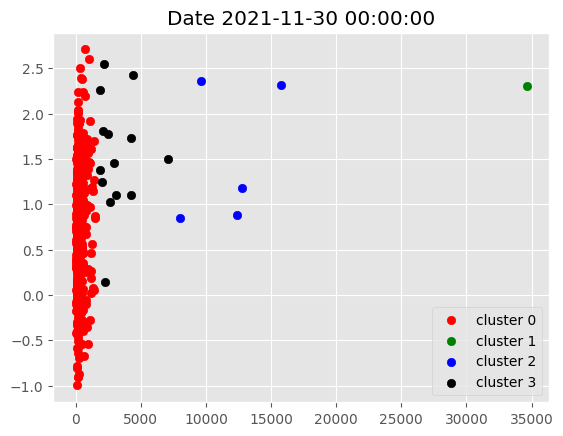

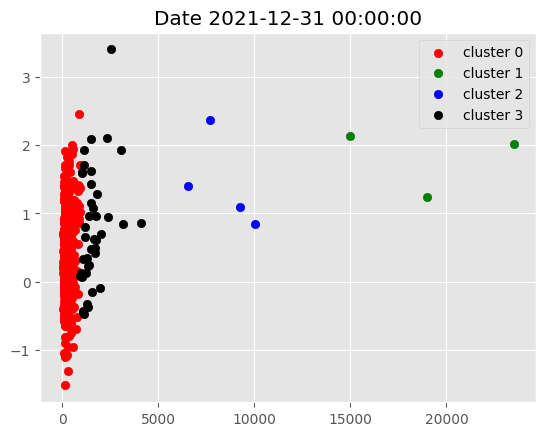

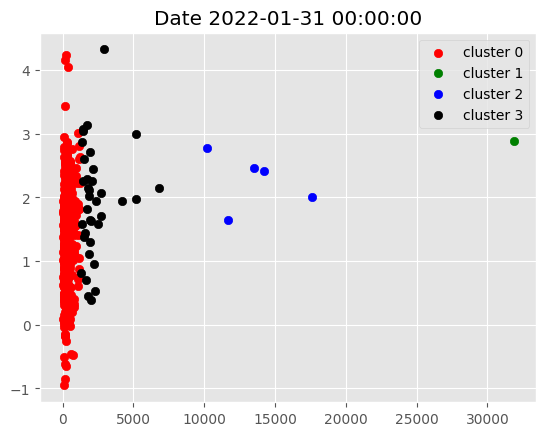

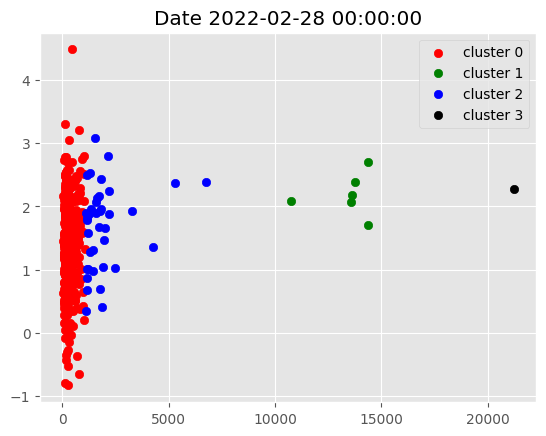

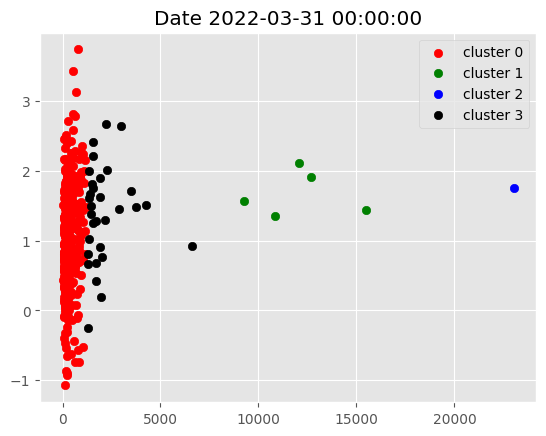

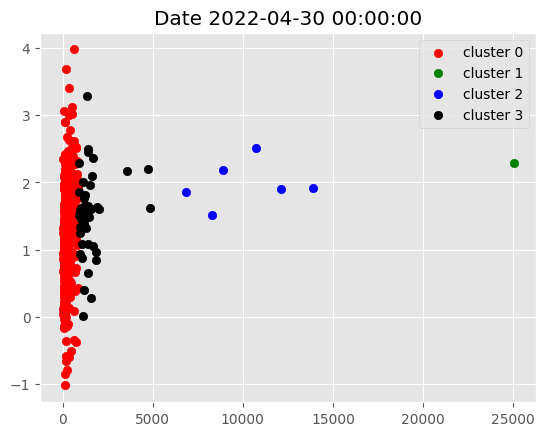

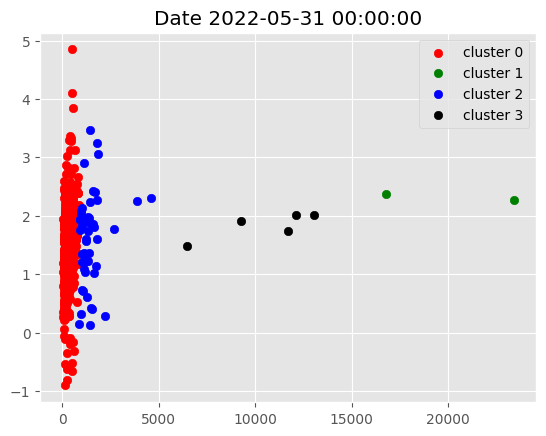

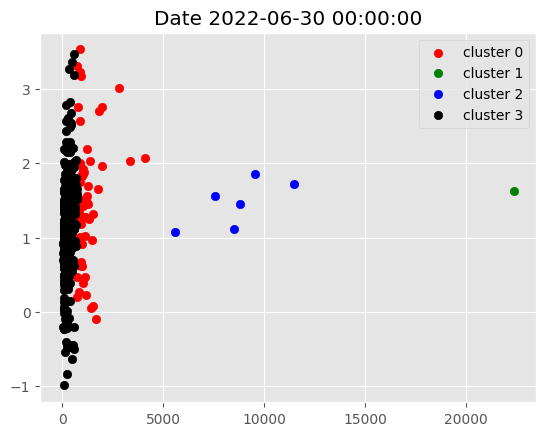

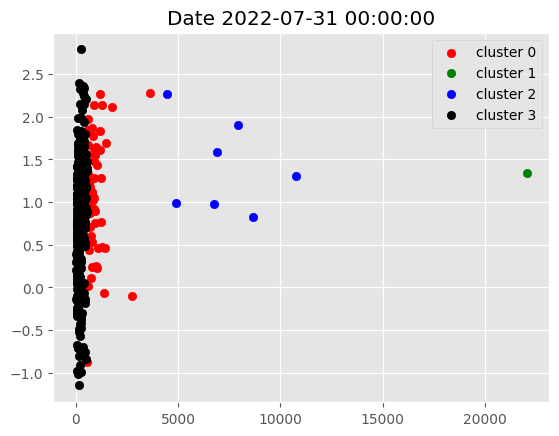

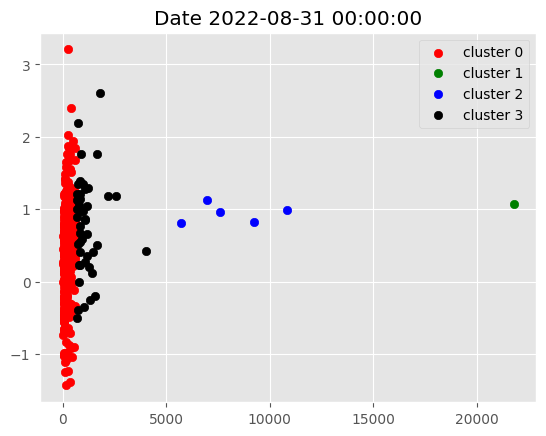

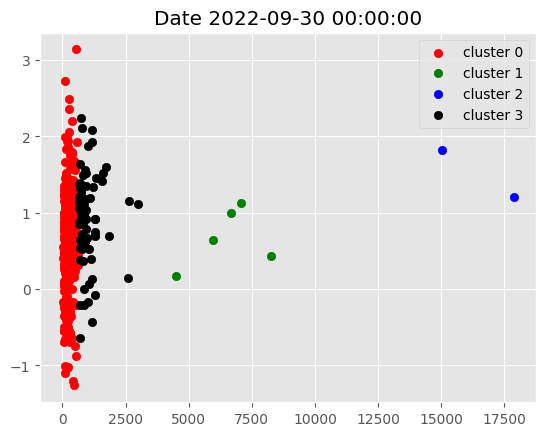

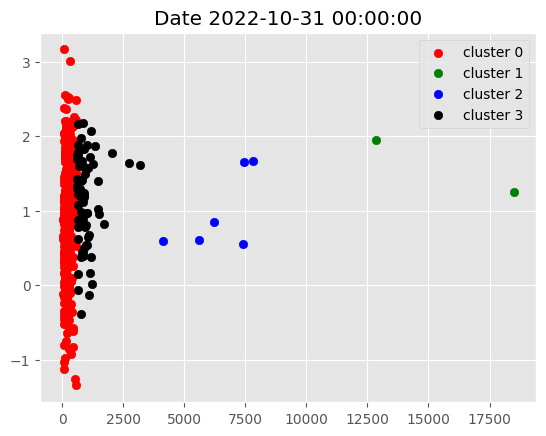

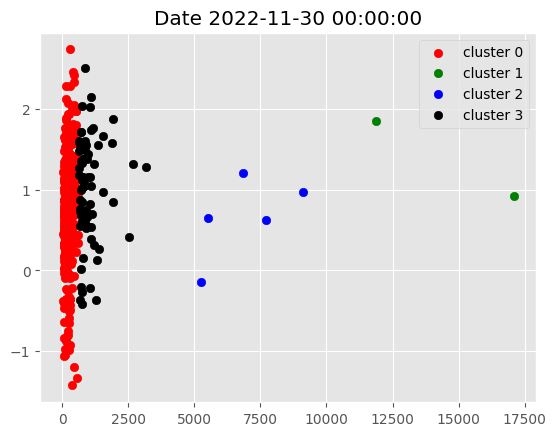

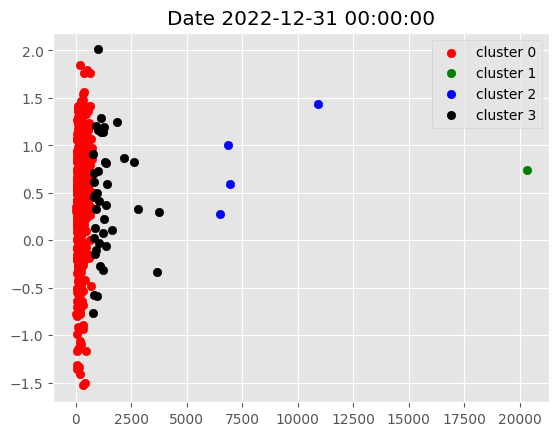

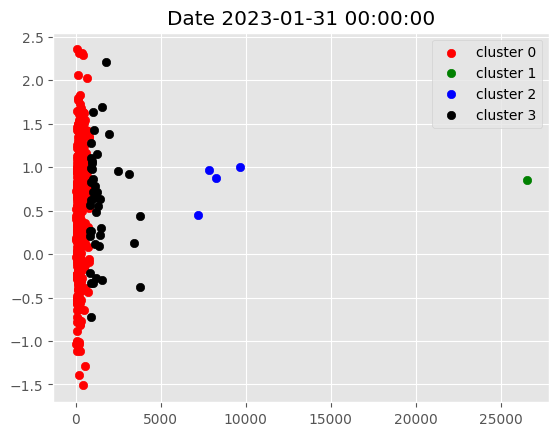

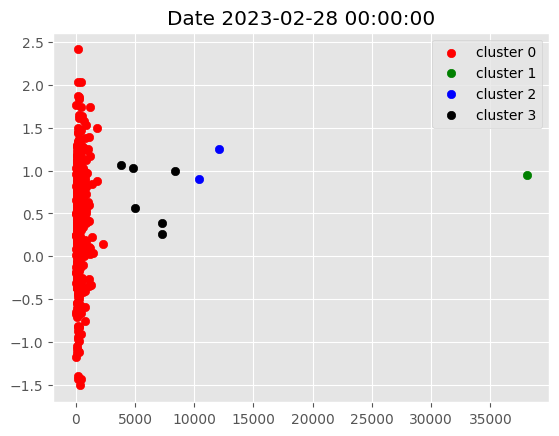

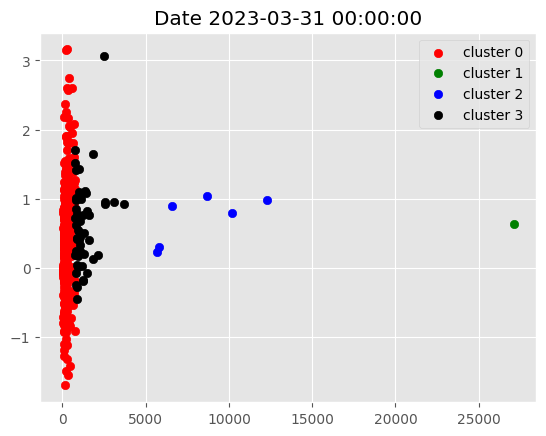

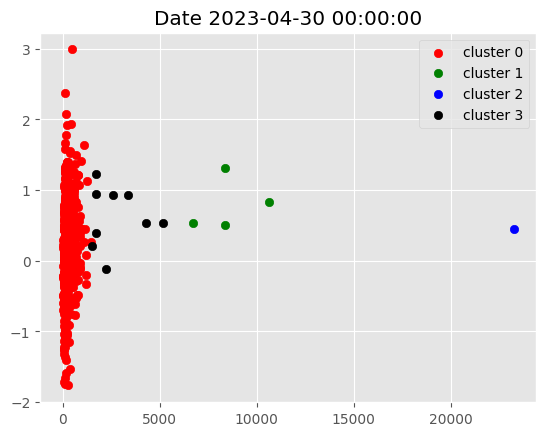

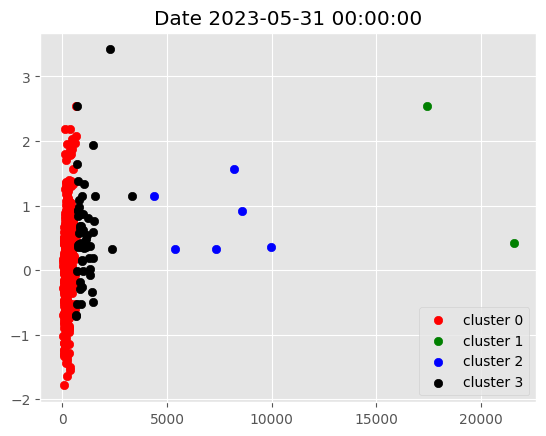

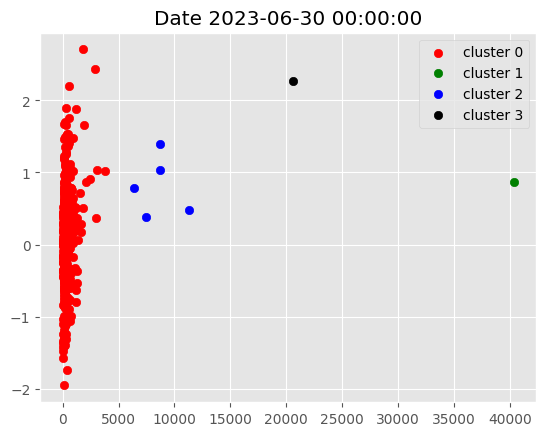

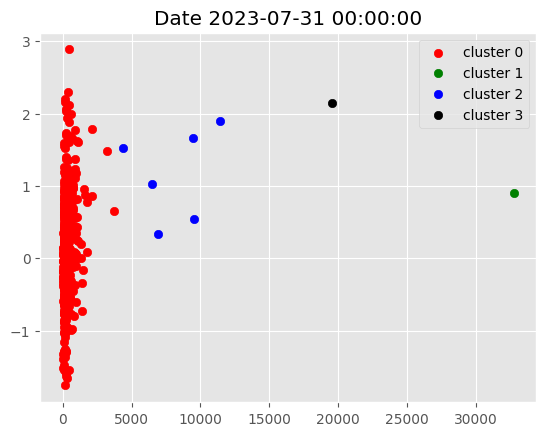

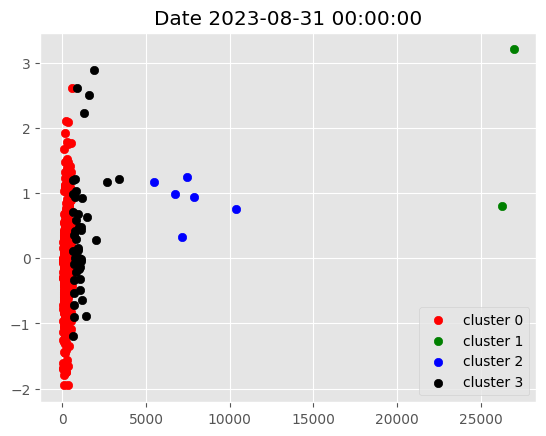

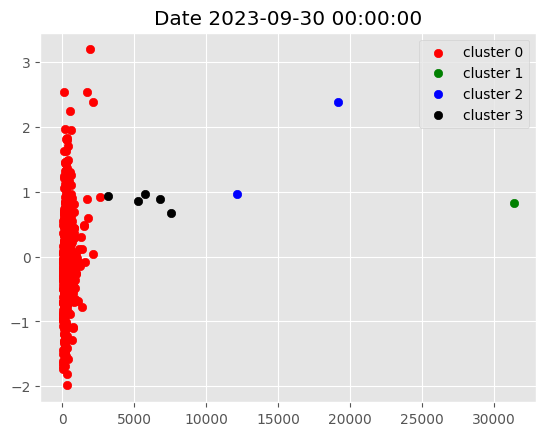

In [42]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [43]:
# for each month select assets based on the cluster and form a portfolio based on efficient,frontier max sharpe ratio optimization

In [46]:
filtered_df = data[data['cluster']==3] 
filtered_df

dollar_volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                         
2016-11-30 BAC       2432.538082         -0.007200  77.645543  2.689407   
           C         1114.621370         -0.017912  69.953114  3.672508   
           GOOG      1553.353099          0.000187  43.081443  3.641807   
           GOOGL     1803.678470          0.000165  42.815691  3.662844   
           JPM       1362.117547         -0.014448  77.382312  4.033283   
...                          ...               ...        ...       ...   
2023-09-30 AMD       5262.551902          0.000339  30.213860  4.563959   
           AMZN      7545.213406          0.000395  29.593940  4.853316   
           GOOGL     3181.391274          0.000264  32.151973  4.871573   
           META      5714.408578          0.000096  48.353552  5.681562   
           MSFT      6791.196349          0.000124  28.403031  5.751005   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2016-11-30 BAC     2.849721  3.010035 -0.806327  1.432476   0.242261   
           C       3.783181  3.893853 -0.622346  1.221124   0.151099   
           GOOG    3.670855  3.699904 -0.932598 -0.394852  -0.033778   
           GOOGL   3.693376  3.723908 -0.917639 -0.439140  -0.042005   
           JPM     4.144974  4.256664 -0.950047  0.961716   0.157522   
...                     ...       ...       ...       ...        ...   
2023-09-30 AMD     4.651509  4.739059  0.854440 -1.552106  -0.092319   
           AMZN    4.925771  4.998226  0.670710 -0.726218  -0.087168   
           GOOGL   4.912076  4.952579  0.930630 -0.192760  -0.055813   
           META    5.708585  5.735609  0.961079 -0.040023   0.010375   
           MSFT    5.794353  5.837700  0.894571 -1.312664  -0.047657   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2016-11-30 BAC      0.161831   0.095131   0.063254   0.061651    0.017685   
           C        0.094483   0.058241   0.033595   0.043191    0.004247   
           GOOG    -0.012460  -0.003931   0.004994   0.009248    0.001716   
           GOOGL   -0.017680  -0.005931   0.005927   0.008773    0.001412   
           JPM      0.101220   0.061576   0.037453   0.042643    0.017934   
...                      ...        ...        ...        ...         ...   
2023-09-30 AMD     -0.084134  -0.055556  -0.003517   0.044644    0.035197   
           AMZN    -0.029227  -0.011328   0.033651   0.046063    0.009102   
           GOOGL   -0.015759   0.024114   0.036428   0.042724    0.024954   
           META    -0.031313   0.013726   0.059010   0.106398    0.064664   
           MSFT    -0.035025  -0.027925   0.014056   0.030496    0.025525   

                     Mkt-RF       SMB       HML       RMW       CMA  cluster  
date       ticker                                                             
2016-11-30 BAC     1.337979 -0.282850  1.460703 -0.585288 -0.776620        3  
           C       1.491437  0.121843  1.226957 -0.263293 -0.356132        3  
           GOOG    1.039386 -0.594965  0.196919 -0.299207 -0.603380        3  
           GOOGL   1.030719 -0.568233  0.197088 -0.297605 -0.614990        3  
           JPM     1.053595 -0.167915  1.279016 -0.322223 -0.654818        3  
...                     ...       ...       ...       ...       ...      ...  
2023-09-30 AMD     1.655888 -0.805338 -0.004674  1.031601 -1.495812        3  
           AMZN    1.286790 -0.524106 -0.013326 -0.866445 -1.315503        3  
           GOOGL   1.116156 -1.128049 -0.087908 -0.541831 -0.601029        3  
           META    0.868435 -1.284613 -1.318601 -0.143562  0.463437        3  
           MSFT    0.994253 -1.154976 -0.423822  0.035751 -0.092517        3  

[7404 rows x 20 columns]

In [53]:
filtered_df = filtered_df.reset_index().set_index(['date','ticker'])
filtered_df

dollar_volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                         
2016-12-01 BAC       2432.538082         -0.007200  77.645543  2.689407   
           C         1114.621370         -0.017912  69.953114  3.672508   
           GOOG      1553.353099          0.000187  43.081443  3.641807   
           GOOGL     1803.678470          0.000165  42.815691  3.662844   
           JPM       1362.117547         -0.014448  77.382312  4.033283   
...                          ...               ...        ...       ...   
2023-10-01 AMD       5262.551902          0.000339  30.213860  4.563959   
           AMZN      7545.213406          0.000395  29.593940  4.853316   
           GOOGL     3181.391274          0.000264  32.151973  4.871573   
           META      5714.408578          0.000096  48.353552  5.681562   
           MSFT      6791.196349          0.000124  28.403031  5.751005   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2016-12-01 BAC     2.849721  3.010035 -0.806327  1.432476   0.242261   
           C       3.783181  3.893853 -0.622346  1.221124   0.151099   
           GOOG    3.670855  3.699904 -0.932598 -0.394852  -0.033778   
           GOOGL   3.693376  3.723908 -0.917639 -0.439140  -0.042005   
           JPM     4.144974  4.256664 -0.950047  0.961716   0.157522   
...                     ...       ...       ...       ...        ...   
2023-10-01 AMD     4.651509  4.739059  0.854440 -1.552106  -0.092319   
           AMZN    4.925771  4.998226  0.670710 -0.726218  -0.087168   
           GOOGL   4.912076  4.952579  0.930630 -0.192760  -0.055813   
           META    5.708585  5.735609  0.961079 -0.040023   0.010375   
           MSFT    5.794353  5.837700  0.894571 -1.312664  -0.047657   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2016-12-01 BAC      0.161831   0.095131   0.063254   0.061651    0.017685   
           C        0.094483   0.058241   0.033595   0.043191    0.004247   
           GOOG    -0.012460  -0.003931   0.004994   0.009248    0.001716   
           GOOGL   -0.017680  -0.005931   0.005927   0.008773    0.001412   
           JPM      0.101220   0.061576   0.037453   0.042643    0.017934   
...                      ...        ...        ...        ...         ...   
2023-10-01 AMD     -0.084134  -0.055556  -0.003517   0.044644    0.035197   
           AMZN    -0.029227  -0.011328   0.033651   0.046063    0.009102   
           GOOGL   -0.015759   0.024114   0.036428   0.042724    0.024954   
           META    -0.031313   0.013726   0.059010   0.106398    0.064664   
           MSFT    -0.035025  -0.027925   0.014056   0.030496    0.025525   

                     Mkt-RF       SMB       HML       RMW       CMA  cluster  
date       ticker                                                             
2016-12-01 BAC     1.337979 -0.282850  1.460703 -0.585288 -0.776620        3  
           C       1.491437  0.121843  1.226957 -0.263293 -0.356132        3  
           GOOG    1.039386 -0.594965  0.196919 -0.299207 -0.603380        3  
           GOOGL   1.030719 -0.568233  0.197088 -0.297605 -0.614990        3  
           JPM     1.053595 -0.167915  1.279016 -0.322223 -0.654818        3  
...                     ...       ...       ...       ...       ...      ...  
2023-10-01 AMD     1.655888 -0.805338 -0.004674  1.031601 -1.495812        3  
           AMZN    1.286790 -0.524106 -0.013326 -0.866445 -1.315503        3  
           GOOGL   1.116156 -1.128049 -0.087908 -0.541831 -0.601029        3  
           META    0.868435 -1.284613 -1.318601 -0.143562  0.463437        3  
           MSFT    0.994253 -1.154976 -0.423822  0.035751 -0.092517        3  

[7404 rows x 20 columns]

In [54]:
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
fixed_dates

{'2016-12-01': ['BAC', 'C', 'GOOG', 'GOOGL', 'JPM', 'MSFT', 'NVDA', 'WFC'],
 '2017-01-01': ['C',
  'DIS',
  'GE',
  'GOOG',
  'GOOGL',
  'GS',
  'JPM',
  'MSFT',
  'NFLX',
  'TSLA',
  'V',
  'WFC'],
 '2017-02-01': ['AAL',
  'ABBV',
  'ABT',
  'AIG',
  'AMD',
  'AMGN',
  'AVGO',
  'AXP',
  'BA',
  'BIIB',
  'BKNG',
  'BMY',
  'BRK-B',
  'CAT',
  'CHTR',
  'CMCSA',
  'CMG',
  'CRM',
  'CSCO',
  'CSX',
  'CVS',
  'CVX',
  'DAL',
  'DD',
  'DIS',
  'EBAY',
  'F',
  'FCX',
  'GILD',
  'GM',
  'GS',
  'HAL',
  'HD',
  'HON',
  'HUM',
  'IBM',
  'INTC',
  'JNJ',
  'KO',
  'LLY',
  'LMT',
  'LOW',
  'LUV',
  'MA',
  'MCD',
  'MCK',
  'MDT',
  'MO',
  'MRK',
  'MS',
  'MU',
  'NKE',
  'ORCL',
  'PEP',
  'PFE',
  'PG',
  'PYPL',
  'REGN',
  'SBUX',
  'SHW',
  'SLB',
  'STZ',
  'T',
  'TGT',
  'TMO',
  'TXN',
  'UNH',
  'UNP',
  'V',
  'VZ',
  'WDC',
  'WMT',
  'XOM'],
 '2017-03-01': ['ABBV',
  'ABT',
  'AIG',
  'AMAT',
  'AMGN',
  'AVGO',
  'BA',
  'BIIB',
  'BKNG',
  'BMY',
  'BRK-B',
  'C',
  

In [56]:
# portfolio optimisation


In [57]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [58]:
#Download Fresh Daily Prices Data only for short listed stocks.

In [59]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  498 of 498 completed


Adj Close                                                \
                     A        AAL        AAPL        ABBV        ABT   
Date                                                                   
2015-11-30   39.152683  39.429928   26.924870   41.160305  38.669407   
2015-12-01   38.441162  41.341236   26.706379   41.776112  39.134258   
2015-12-02   37.841991  41.876389   26.465118   40.855938  38.927658   
2015-12-03   37.589203  41.350780   26.219318   39.723408  38.006546   
2015-12-04   38.478611  42.975380   27.091024   40.473713  38.996513   
...                ...        ...         ...         ...        ...   
2023-09-25  111.714767  12.910000  175.848328  153.117371  96.933411   
2023-09-26  110.507202  12.700000  171.733749  152.384705  95.700241   
2023-09-27  110.277657  12.610000  170.205750  151.612442  95.004089   
2023-09-28  111.774643  12.920000  170.465424  150.741165  97.579834   
2023-09-29  111.595001  12.810000  170.984741  147.582764  96.316818   

                                                                      ...  \
                 ACGL         ACN        ADBE         ADI        ADM  ...   
Date                                                                  ...   
2015-11-30  24.156668   94.345917   91.459999   51.940926  29.150969  ...   
2015-12-01  24.400000   95.146652   92.550003   51.890350  29.318739  ...   
2015-12-02  24.276667   94.671516   92.019997   51.525581  29.174932  ...   
2015-12-03  24.110001   93.210808   89.910004   50.091969  28.447966  ...   
2015-12-04  24.540001   96.000183   92.580002   50.227688  28.735558  ...   
...               ...         ...         ...         ...        ...  ...   
2023-09-25  81.150002  315.680695  511.600006  174.607285  76.823753  ...   
2023-09-26  81.260002  309.327057  506.299988  171.531769  75.601334  ...   
2023-09-27  81.080002  313.081512  502.600006  171.999573  75.889542  ...   
2023-09-28  81.639999  299.527710  504.670013  175.582687  75.571518  ...   
2023-09-29  79.709999  305.841522  509.899994  174.268875  74.955330  ...   

             Volume                                                         \
               WYNN      XEL       XOM     XRAY      XYL      YUM      ZBH   
Date                                                                         
2015-11-30  2878100  3597100  17729200   981300  1470200  4477490  1600517   
2015-12-01  6375200  4161500  13917000  1004200   756900  7057517  1718967   
2015-12-02  6911800  3471100  16300000  1153500   615600  4914542  1630078   
2015-12-03  3747600  7790800  14870300  1941100   734800  5513646  1960914   
2015-12-04  4241000  5089900  20156400  1971200  1247300  5537710  1133000   
...             ...      ...       ...      ...      ...      ...      ...   
2023-09-25  1387800  3617800  11316000  1957800  1702000  1048500   886700   
2023-09-26  1454000  6275500  11805400  1827800  1322400  1500600  3610500   
2023-09-27  2050000  4481200  23976200  2036000  1320200  1922300  3121500   
2023-09-28  1290400  4362200  16808100  1838100  1453500  1722700  1939000   
2023-09-29  1326800  4078900  18810700  1236800  1833900  2610000  1986900   

                                      
              ZBRA     ZION      ZTS  
Date                                  
2015-11-30  436500  2614000  3481900  
2015-12-01  329600  2533000  2956900  
2015-12-02  370300  2483900  2335100  
2015-12-03  391700  2307600  2465300  
2015-12-04  482600  3099800  2237600  
...            ...      ...      ...  
2023-09-25  314500  1370600  1551100  
2023-09-26  355400  1586100  1463200  
2023-09-27  364600  3779200  1450400  
2023-09-28  611800  2233500  1115900  
2023-09-29  390000  2926900  1498500  

[1972 rows x 2988 columns]

In [60]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2016-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-10-01, Continuing with Equal-Weights

,Strategy Return
date,
2016-12-01,-0.002138
2016-12-02,-0.004682
2016-12-05,0.021624
2016-12-06,0.007169
2016-12-07,0.018695
...,...
2023-09-25,0.003247
2023-09-26,-0.014066
2023-09-27,0.000311


In [61]:
#Visualize Portfolio returns and compare to SP500 returns.

In [62]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2016-12-01,-0.002138,-0.003682
2016-12-02,-0.004682,0.000501
2016-12-05,0.021624,0.005991
2016-12-06,0.007169,0.003163
2016-12-07,0.018695,0.012996
...,...,...
2023-09-25,0.003247,0.004196
2023-09-26,-0.014066,-0.014800
2023-09-27,0.000311,0.000399
2023-09-28,0.005701,0.005781


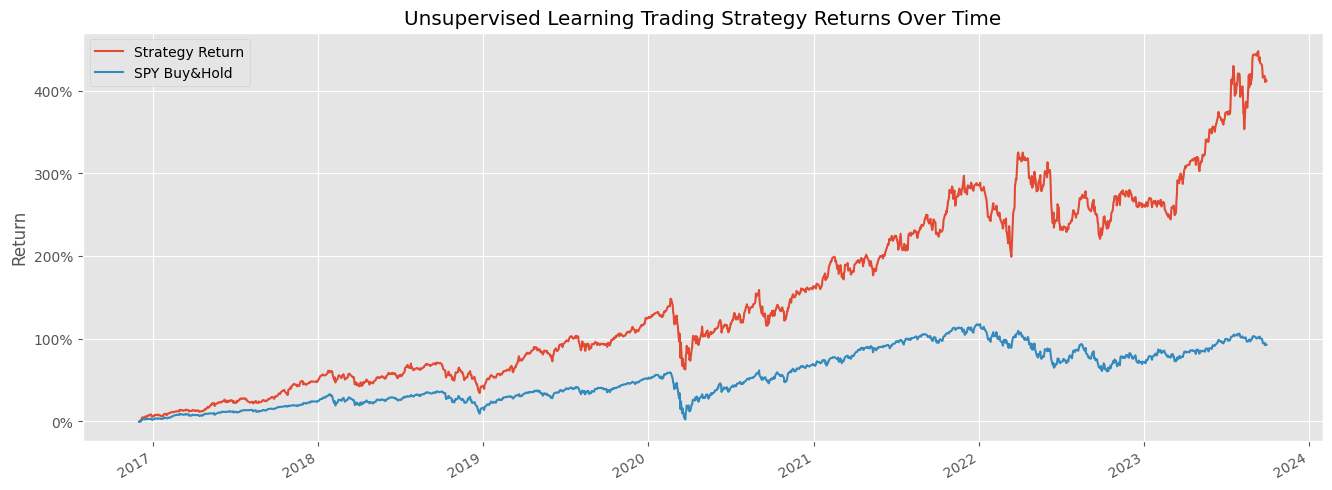

In [63]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()